In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# to output everything in a cell instead of only the last output
# 这两行代码用来设置 IPython 的交互模式，允许在一个单元格中显示多个输出，而不仅仅是最后一个输出。


%matplotlib inline
# 这行命令用于在 Jupyter 笔记本中内嵌绘图，使得生成的图表可以直接显示在笔记本中

# standard imports
import numpy as np
#import xarray as xr
import matplotlib.pyplot as plt

# import numpy as np：导入 NumPy 库，用于处理数值型数据。
# import xarray as xr：导入 xarray 库，这是一个用于处理多维数组数据（如气象数据）的强大工具。
# import matplotlib.pyplot as plt：导入 matplotlib 的 pyplot 模块，这是 Python 中一个常用的绘图库。
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras.utils import to_categorical

In [2]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np

# 在导入 TensorFlow 或任何操作之前设置 GPU 配置
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')  # 仅使用第一个 GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)  # 动态分配显存
        print("Using GPU for training.")
    except RuntimeError as e:
        print("GPU configuration error:", e)

Using GPU for training.


## import data

In [3]:
SSH_train = np.expand_dims(np.load(r'D:\jupyterProject\eddy\data\data2001-2020\trainSla_nanhai_Augmentation.npy'),3) #you can use all the region, in here I selected a box of 168*168 size
# np.expand_dims(..., 3)：expand_dims 函数用于在数组中增加一个新的轴。参数 3 表示新轴被添加在原数组的第四个维度（索引从0开始）。这通常用于确保数据的维度与某些特定的数据处理或机器学习模型的输入要求相匹配。
#######
#Keras要求输入的数据具有四个维度 (batch_size, height, width, channels)，其中 channels 表示通道数。这里通过 expand_dims 添加了一个通道维度，表示这些数据是单通道的（灰度图像）。
Seg_train = np.expand_dims(np.load(r'D:\jupyterProject\eddy\data\data2001-2020\trainEddy_nanhai_Augmentation.npy'),3)

######
SSH_train.shape
#####\
Seg_train.shape
mask= np.load(r'D:\jupyterProject\eddy\data\data2001-2020\mask_nanhai_2001-2020.npy')
mask.shape
# 第四个维度为 1，表示这些图像是单通道的，即灰度图像（与彩色图像相比，彩色图像通常有三个通道表示红、绿、蓝）。

(28000, 96, 96, 1)

(28000, 96, 96, 1)

(28000, 96, 96)

In [4]:
# 总数据大小
total_images = SSH_train.shape[0]

# 随机选取 7300 个索引
random_indices = np.random.choice(total_images, 7000, replace=False)
# 根据随机选择的索引，从 SSH_train 和 Seg_train 中选取对应的图像。这样可以减少数据量，使得模型训练在合理的时间内完成，同时确保训练数据的多样性
# 选取对应的图像
SSH_train = SSH_train[random_indices]
Seg_train = Seg_train[random_indices]
mask = mask[random_indices]

SSH_train.shape
Seg_train.shape
mask.shape

max(random_indices)

(7000, 96, 96, 1)

(7000, 96, 96, 1)

(7000, 96, 96)

27996

In [5]:
#海平面异常数据
Seg_train = np.expand_dims(np.load(r'D:\jupyterProject\eddy\data\2001_2022\AugmentationData\trainEddy_nanhai_Augmentation_2001_2022.npy'),3) #you can use all the region, in here I selected a box of 168*168 size
# np.expand_dims(..., 3)：expand_dims 函数用于在数组中增加一个新的轴。参数 3 表示新轴被添加在原数组的第四个维度（索引从0开始）。这通常用于确保数据的维度与某些特定的数据处理或机器学习模型的输入要求相匹配。
#######
#旋涡数据
SSH_train = np.expand_dims(np.load(r'D:\jupyterProject\eddy\data\2001_2022\AugmentationData\trainSla_nanhai_Augmentation_2001_2022.npy'),3)

######
#图像数量，图像大小（高，宽），通道数
SSH_train.shape
#####
Seg_train.shape
mask= np.load(r'D:\jupyterProject\eddy\data\2001_2022\mask\mask_nanhai_2001_2022.npy')
mask.shape
# 第四个维度为 1，表示这些图像是单通道的，即灰度图像（与彩色图像相比，彩色图像通常有三个通道表示红、绿、蓝）。

# 总数据大小
total_images = SSH_train.shape[0]
# 随机选取 7300 个索引
random_indices = np.random.choice(total_images, 16000, replace=False)
# 根据随机选择的索引，从 SSH_train 和 Seg_train 中选取对应的图像。这样可以减少数据量，使得模型训练在合理的时间内完成，同时确保训练数据的多样性
# 选取对应的图像
SSH_train = SSH_train[random_indices]
Seg_train = Seg_train[random_indices]
mask = mask[random_indices]

SSH_train.shape
Seg_train.shape
mask.shape

max(random_indices)
mask[1]
Seg_train_categor = to_categorical(np.reshape(Seg_train[:,:,:,0],(16000,88*80)),3)#去除最后一个维度（通道维度），reshape成（7000*96*96）大小，并进行独热编码，类型有3种

(32140, 88, 80, 1)

(32140, 88, 80, 1)

(32140, 88, 80)

(16000, 88, 80, 1)

(16000, 88, 80, 1)

(16000, 88, 80)

32138

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

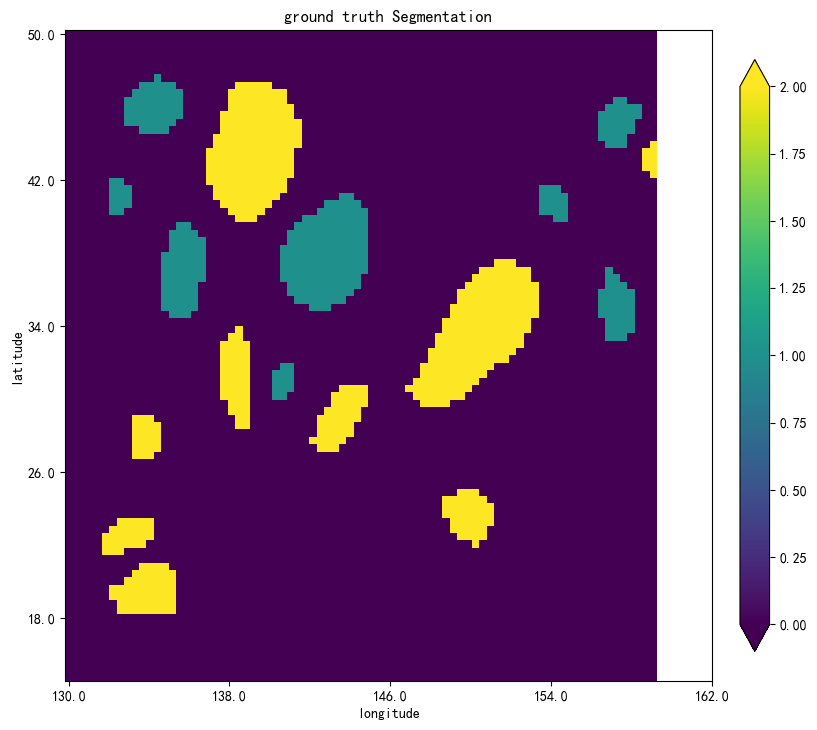

In [6]:
# 自定义的经度和纬度范围
# longitudes = np.linspace(100, 124, SSH_train.shape[1])
# latitudes = np.linspace(24, 0, SSH_train.shape[2])

# 使用 np.random.randint(0, len(SSH_train)) 随机生成一个索引 randindex，范围在 0 到 len(SSH_train) 之间。这个索引用于从训练数据集中随机选择一张图像
# randindex=np.random.randint(0,len(SSH_train))

randindex=6996


#标签颜色
#alphaData=mask[randindex,:,:].astype(float)
#cmap_gray = mcolors.ListedColormap(['white', 'gray'])

plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体作为默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题
plt.figure(figsize=(20, 10))  #图形的大小为 20 英寸宽，10 英寸高。


# plt.subplot(121)
# plt.imshow(SSH_train[randindex,:,:,0], cmap='viridis',vmin=-0.35, vmax=0.35)
# plt.colorbar(extend='both', fraction=0.042, pad=0.04)
# # plt.imshow(mask[randindex,:,:], cmap=cmap_gray, alpha=alphaData)
# #plt.clim(-0.25,0.25)
# #plt.axis('off')  #关闭坐标轴显示（plt.axis('off')）。
# plt.xticks(ticks=np.linspace(0, SSH_train.shape[1] - 1, 5), labels=np.linspace(130, 162, 5))
# plt.yticks(ticks=np.linspace(0, SSH_train.shape[2] - 1, 5), labels=np.linspace(50, 18, 5))
# plt.xlabel('经度')
# plt.ylabel('纬度')
# plt.title('SLA');

plt.subplot(122)
plt.imshow(Seg_train[randindex,:,:,0], cmap='viridis', vmin=0, vmax=2)
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
# plt.imshow(mask[randindex,:,:], cmap=cmap_gray, alpha=alphaData)
#plt.clim(-0.25,0.25)
# plt.axis('off')
plt.xticks(ticks=np.linspace(0, Seg_train.shape[1] - 1, 5), labels=np.linspace(130, 162, 5))
plt.yticks(ticks=np.linspace(0, Seg_train.shape[2] - 1, 5), labels=np.linspace(50, 18, 5))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('ground truth Segmentation');

# plt.show()



<Figure size 1500x800 with 0 Axes>

([<matplotlib.axis.XTick at 0x2295465f970>,
 [Text(0.0, 0, '130.0'),
  Text(17.4, 0, '136.4'),
  Text(34.8, 0, '142.8'),
  Text(52.199999999999996, 0, '149.2'),
  Text(69.6, 0, '155.6'),
  Text(87.0, 0, '162.0')])

([<matplotlib.axis.YTick at 0x2295465fa90>,
 [Text(0, 0.0, '50.0'),
  Text(0, 15.8, '43.6'),
  Text(0, 31.6, '37.2'),
  Text(0, 47.400000000000006, '30.8'),
  Text(0, 63.2, '24.4'),
  Text(0, 79.0, '18.0')])

Text(0.5, 0, '经度')

Text(0, 0.5, '纬度')

Text(0.5, 1.0, '中尺度涡分割标签')

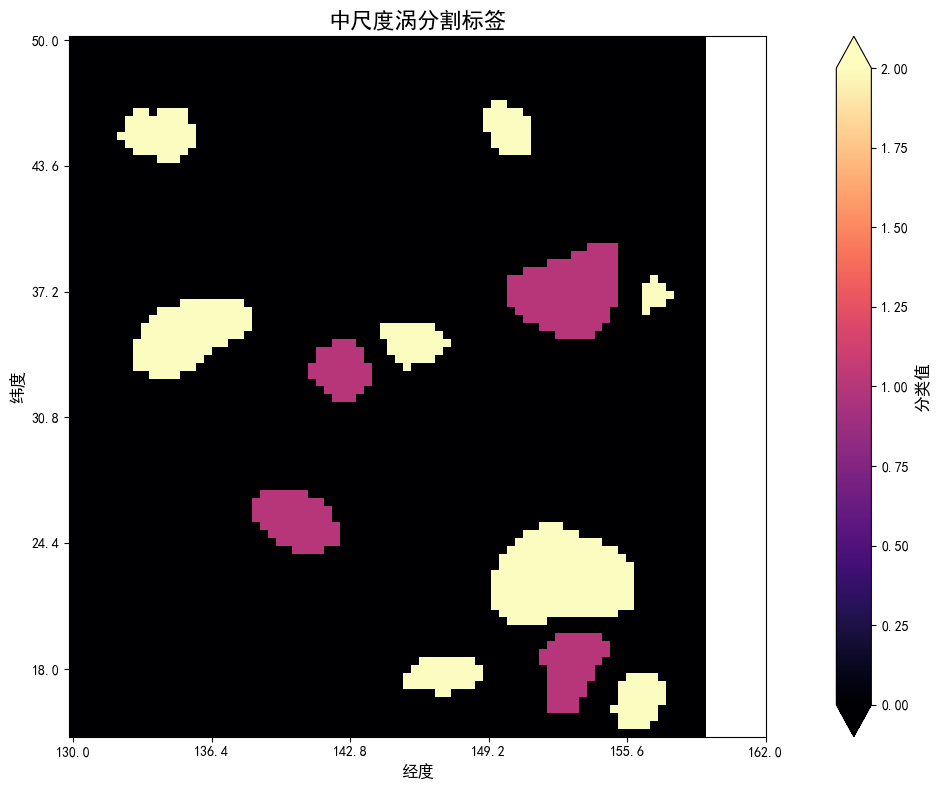

In [5]:
randindex = 6996
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体作为默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

plt.figure(figsize=(15, 8))  # 调整图形大小为 15 英寸宽，8 英寸高

# 显示中尺度涡的标签
plt.imshow(Seg_train[randindex, :, :, 0], cmap='magma', vmin=0, vmax=2)
cbar = plt.colorbar(extend='both', fraction=0.03, pad=0.05)  # 调整颜色条的位置与大小
cbar.set_label('分类值', fontsize=12)  # 增加颜色条标签

# 调整经纬度刻度与标签
plt.xticks(
    ticks=np.linspace(0, Seg_train.shape[1] - 1, 6), 
    labels=np.round(np.linspace(130, 162, 6), 1), fontsize=10
)
plt.yticks(
    ticks=np.linspace(0, Seg_train.shape[2] - 1, 6), 
    labels=np.round(np.linspace(50, 18, 6), 1), fontsize=10
)

# 添加标签与标题
plt.xlabel('经度', fontsize=12)
plt.ylabel('纬度', fontsize=12)
plt.title('中尺度涡分割标签', fontsize=16, fontweight='bold')

# 显示最终的图
plt.tight_layout()  # 自动调整布局
plt.show()

In [7]:
from bokeh.plotting import figure, show
from bokeh.models import ColorBar, LinearColorMapper
from bokeh.io import output_notebook
import numpy as np

randindex = 3000

output_notebook()  # 在 Notebook 环境中使用

# 创建颜色映射
mapper = LinearColorMapper(palette="Viridis256", low=0, high=2)

# 绘制图像
p = figure(title="中尺度涡分割标签", x_axis_label="经度", y_axis_label="纬度",
           x_range=(130, 162), y_range=(50, 18), tools="pan,box_zoom,reset")

p.image(image=[Seg_train[randindex, :, :, 0]], x=130, y=18, dw=32, dh=32, color_mapper=mapper)

# 添加颜色条
color_bar = ColorBar(color_mapper=mapper, label_standoff=12, location=(0, 0), title="分类值")
p.add_layout(color_bar, 'right')

show(p)

Loading BokehJS ...

GlyphRenderer(id='p1571', ...)

## Eddynet 

In [7]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Activation, Reshape, Permute, Lambda
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, AlphaDropout, concatenate, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, add
from tensorflow.keras.utils import to_categorical

# from keras import utils as np_utils
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
# 这段代码导入了用于构建、训练和可视化深度学习模型的各种库和模块。
from tensorflow.keras.models import Model, load_model
# Model：用于定义和构建Keras模型。
# load_model：用于加载保存的Keras模型。

from tensorflow.keras.layers import Activation, Reshape, Permute, Lambda
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, AlphaDropout, concatenate, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, add
# 这些是Keras中用于构建神经网络的各种层类型
# Activation：用于应用激活函数。
# Reshape：用于重新调整张量的形状。
# Permute：用于重排张量的维度。
# Lambda：用于包装任意表达式作为层。
# Input：用于定义输入层。
# Conv2D：二维卷积层。
# MaxPooling2D：二维最大池化层。
# Dropout：用于在训练过程中随机丢弃一些神经元以防止过拟合。
# UpSampling2D：用于对数据进行上采样。
# AlphaDropout：一种特殊的dropout层，适用于self-normalizing神经网络（如SELU）。
# concatenate：用于连接层。
# Conv2DTranspose：二维转置卷积层，用于上采样。
# BatchNormalization：用于对前一层的输出进行批量标准化。
# LeakyReLU：Leaky ReLU激活函数。
# add：用于将层的输出相加


from tensorflow.keras.utils import to_categorical
# np_utils：包含一些实用函数，例如将类向量转换为二进制类别矩阵。

# from keras import utils as np_utils
# from keras.optimizers import Adam

from tensorflow.keras.optimizers import Adam
# Adam优化器，从TensorFlow中的Keras模块导入，通常用于替代经典的随机梯度下降算法进行神经网络训练。

from tensorflow.keras import backend as K
# backend：提供了Keras的后端接口，可以与TensorFlow、Theano或CNTK配合使用。

from tensorflow.keras import regularizers
# regularizers：包含正则化器，用于防止过拟合。

import matplotlib.pyplot as plt
import numpy as np
import pickle
from IPython.display import SVG 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
# matplotlib.pyplot：用于数据可视化。
# numpy：用于数值计算和数组操作。
# pickle：用于序列化和反序列化Python对象。
# IPython.display.SVG：用于在Jupyter Notebook中显示SVG格式的图像。
# model_to_dot：将Keras模型转换为Graphviz的DOT格式，便于可视化。
# ModelCheckpoint：回调函数，用于保存模型检查点。
# EarlyStopping：回调函数，当监控指标不再改善时停止训练。
# LearningRateScheduler：回调函数，用于动态调整学习率。
# ReduceLROnPlateau：回调函数，当监控指标不再改善时减少学习率。

import numpy as np
import pickle
from IPython.display import SVG 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

In [8]:
# 这段代码将 Seg_train 数据转换为分类格式，并输出转换后的形状。以下是逐行分析

Seg_train_categor = to_categorical(np.reshape(Seg_train[:,:,:,0],(16000,88*80)),3)
# Seg_train[:,:,:,0]：获取 Seg_train 的第一个通道数据，形状为 (7300, 128, 128)。
# np.reshape(..., (7300, 128*128))：将 Seg_train 重塑为 (7300, 128*128) 的二维数组，每张图像的大小从 128x128 变为 16384 的一维数组。
# np_utils.to_categorical(..., 3)：将重塑后的 Seg_train 转换为分类格式。3 表示类别的数量，因此输出将是一个 (7300, 128*128, 3) 的数组，
# 每个像素点用一个3维的one-hot向量表示类别。

# One-hot 向量是一种表示分类数据的常用方法。它的特点是：在向量中，只有一个位置是 1，其余位置都是 0。这个位置对应了某个类别。例如，假设我们有 3 个类别：A、B、C，可以这样表示：

# A -> [1, 0, 0]
# B -> [0, 1, 0]
# C -> [0, 0, 1]
# 对于一个有 n 个类别的数据，one-hot 向量的长度为 n。

# 在您的代码中的应用
# 您有一个包含 7300 张图像的分割标签数据集 Seg_train。每张图像的尺寸是 128x128 像素，每个像素点可以属于 3 个类别之一（例如，背景、类型1涡旋、类型2涡旋）。



Seg_train_categor.shape
# 输出 Seg_train_categor 的形状，以确认转换后的数据格式。

(16000, 7040, 3)

In [9]:
Seg_train_categor[1,6000]

array([1., 0., 0.], dtype=float32)

In [10]:
# 这两段代码定义了两个函数，用于在卷积神经网络中执行卷积操作和转置卷积操作，并在每次卷积操作后进行批量归一化和激活

def ConvBNActi(nf,ker,inputs):
    conv1 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)  #卷积
    conv1 = BatchNormalization()(conv1)  #批量归一化
    conv1 = Activation('relu')(conv1) #激活
    #conv1 = LeakyReLU(0.3)(conv1)
    return conv1

# 参数：
# nf：卷积核的数量（输出通道数）。
# ker：卷积核的大小。
# inputs：输入张量

#卷积
# 使用指定数量和大小的卷积核执行 2D 卷积操作。
# padding="same" 表示输出尺寸与输入尺寸相同。
# kernel_initializer='he_normal' 使用 He 正态分布初始化卷积核。
# use_bias=False 表示不使用偏置项

# 批量归一化
# 对卷积结果进行批量归一化，稳定训练过程并加快收敛速度。

# 激活:
# 使用 ReLU 激活函数。
# 注释掉的 LeakyReLU 是另一种激活函数，您可以选择使用其中之一。

# 返回经过卷积、批量归一化和激活后的张量
  
def ConvTranspBNActi(nf,ker,inputs):
    conv1 = Conv2DTranspose(nf, ker, strides=(2, 2), padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    #conv1 = LeakyReLU(0.3)(conv1)
    return conv1

# 这个函数使用了 Conv2DTranspose 层，它的目的是将输入特征图上采样至更高分辨率。
# 这在生成对抗网络（GANs）和自动编码器（Autoencoders）中非常常见，
# 用于恢复图像的空间分辨率

# 参数：
# nf：转置卷积核的数量（输出通道数）。
# ker：转置卷积核的大小。
# inputs：输入张量。

# 转置卷积
# 使用指定数量和大小的转置卷积核执行 2D 转置卷积操作。
# strides=(2, 2) 表示步幅为 2，通常用于上采样。
# padding="same" 表示输出尺寸与输入尺寸相同。
# kernel_initializer='he_normal' 使用 He 正态分布初始化卷积核。
# use_bias=False 表示不使用偏置项。

# 批量归一化
# 对转置卷积结果进行批量归一化。

# 激活
# 使用 ReLU 激活函数。
# 注释掉的 LeakyReLU 是另一种激活函数，您可以选择使用其中之一。
# 返回结果：

# 返回经过转置卷积、批量归一化和激活后的张量。




# 转置卷积是一种用于上采样的操作，它通过对输入特征图进行卷积反向传播来生成更高分辨率的特征图。
# 其核心目的是恢复卷积操作前的空间分辨率。具体过程如下
# 步幅和填充：
# 使用步幅和填充参数与卷积相同，但方向相反，从而增加输出的空间尺寸。
# 原理：
# 转置卷积通过将输入数据分布到更大的输出空间，类似于卷积过程的逆操作

# 转置卷积之所以被称为反卷积，主要是因为它们在特定上下文中执行类似的功能，
# 即恢复原始输入的空间尺寸。然而，转置卷积并不是严格意义上的卷积逆操作，
# 因为它不直接计算卷积的数学逆。

In [11]:
width = 80
height = 88
nbClass = 3
nf = 16
ker = 3
# 参数设置
# width 和 height：图像的宽度和高度，均为 96 像素。
# nbClass：类别的数量，这里是 3 类。
# nf：卷积核的数量（输出通道数），初始值为 16。
# ker：卷积核的大小，3x3。

###################################### INPUT LAYER 输入层
# Input 层定义输入图像的形状，大小为 96x96单通道（灰度图像）。
img_input = Input(shape=(height, width, 1))


######################################ENCODER 编辑器部分
conv1 = ConvBNActi(nf,ker,img_input)
conv1 = ConvBNActi(nf,ker,conv1)
conv1 = Dropout(0.2)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = ConvBNActi(nf,ker,pool1)
conv2 = ConvBNActi(nf,ker,conv2)
conv2 = Dropout(0.3)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = ConvBNActi(nf,ker,pool2)
conv3 = ConvBNActi(nf,ker,conv3)
conv3 = Dropout(0.4)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
# 三层卷积模块，每层包含两个卷积层、一个 Dropout 层和一个最大池化层。
# MaxPooling2D 层将输入尺寸减半，以减少空间维度

#######################################center  中心部分
convC = ConvBNActi(nf,ker,pool3)
convC = ConvBNActi(nf,ker,convC)
convC = Dropout(0.5)(convC)
# 中心部分是两层卷积层和一个 Dropout 层，不进行池化操作

#######################################DECODER解码器部分
#up3 = concatenate([ConvTranspBNActi(nf,ker,convC), conv3])
up3 = concatenate([UpSampling2D((2,2))(convC), conv3])
decod3 = ConvBNActi(nf,ker,up3)
decod3 = ConvBNActi(nf,ker,decod3)
decod3 = Dropout(0.4)(decod3)

#up2 = concatenate([ConvTranspBNActi(nf,ker,decod3), conv2])
up2 = concatenate([UpSampling2D((2,2))(decod3), conv2])
decod2 = ConvBNActi(nf,ker,up2)
decod2 = ConvBNActi(nf,ker,decod2)
decod2 = Dropout(0.3)(decod2)

#up1 = concatenate([ConvTranspBNActi(nf,ker,decod2), conv1])
up1 = concatenate([UpSampling2D((2,2))(decod2), conv1])
decod1 = ConvBNActi(nf,ker,up1)
decod1 = ConvBNActi(nf,ker,decod1)
decod1 = Dropout(0.2)(decod1)

# 解码器部分包含三层卷积模块，每层包含两个卷积层、一个 Dropout 层和一个上采样操作。
# 使用 UpSampling2D 进行上采样，将输入的空间尺寸扩大一倍。

####################################### Segmentation Layer 分割层
x = Conv2D(nbClass, (1, 1), padding="valid", use_bias=False)(decod1) 
x = Reshape((height * width, nbClass))(x) 
x = Activation("softmax")(x)
# Conv2D(nbClass, (1, 1), padding="valid", use_bias=False)：使用 1x1 卷积将通道数转换为类别数。
# Reshape((height * width, nbClass))：将输出重新形状化为 (height * width, nbClass)。
# Activation("softmax")：应用 softmax 激活函数，输出每个像素属于各个类别的概率





eddynet = Model(img_input, x)
eddynet.summary()
# 构建模型
# 使用 Model 类构建模型，将输入和输出连接起来。
# 打印模型摘要以检查网络结构。



# 解释
# 这个模型实现了一个典型的 U-Net 结构，适用于图像分割任务。
# 编码器部分逐步减少空间维度，提取特征；
# 解码器部分逐步恢复空间维度，生成与输入图像相同大小的分割图。

# 进一步优化
# 您可以调整 nf 的值，使其在每个编码层加倍，以提取更多特征。
# 使用 Conv2DTranspose 而不是 UpSampling2D 可能会提高解码器的表现，
# 因为 Conv2DTranspose 能学习到更复杂的上采样模式。

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Activation, BatchNormalization
from tensorflow.keras.utils import plot_model

# 保存模型图
#plot_model(eddynet, to_file="eddynet_model.png", show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 88, 80, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 88, 80, 16)   144         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 88, 80, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 88, 80, 16)   0           ['batch_normalization[0][0]']

 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 22, 20, 16)   0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 22, 20, 16)   2304        ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 22, 20, 16)  64          ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 22, 20, 16)   0           ['batch_normalization_9[0][0]']  
          

In [10]:
print("Model output shape:", eddynet.output_shape)

Model output shape: (None, 7040, 3)


### calculate weights (some heavy data imbalance out there...)

In [12]:

# 这段代码用于计算分割数据集中每个类别的权重，以处理数据不平衡的问题。以下是详细解释

unique, counts = np.unique(Seg_train, return_counts=True)
# np.unique(Seg_train, return_counts=True)：
# 这个函数会返回数组 Seg_train 中的唯一值和每个唯一值的计数。
# unique 是唯一值的数组，counts 是每个唯一值对应的计数。

dict(zip(unique, counts))
# dict(zip(unique, counts))：
# 将 unique 和 counts 转换成字典格式，其中键是唯一值，值是对应的计数。
# 这使得我们能够更方便地查看每个类别在数据集中的数量。

# 根据您提供的结果 {0: 95145706, 1: 11705580, 2: 12751914}，
# 我们可以看到类别 0 的像素点数量明显多于类别 1 和类别 2。
# 为了处理这种数据不平衡，我们需要计算每个类别的权重，
# 以便在训练过程中能够平衡各个类别的影响
# gpt提供了另外一种计算权重的方式


{0: 97907830, 1: 7066242, 2: 7665928}

In [13]:
# 这一格代码是上一格的例子说明
# 举例说明
# 假设 Seg_train 数据集中包含三个类别（0, 1, 2），
# 计算出来的 unique 和 counts 可能是这样的：

# unique = [0, 1, 2]
# counts = [50000, 3000, 2000]


# 通过 dict(zip(unique, counts)) 得到的字典会是：
# {0: 50000, 1: 3000, 2: 2000}
# 这意味着类别 0 有 50000 个像素点，类别 1 有 3000 个像素点，类别 2 有 2000 个像素点。
# 这种不平衡可能会影响模型的训练效果，因此需要计算权重来平衡每个类别的影响。




# 计算权重
#为了处理数据不平衡问题，通常会根据类别的数量计算每个类别的权重。
# 权重的计算方法之一是将每个类别的总样本数除以该类别的样本数。
# 下面是一个示例代码，用于计算权重并将其应用到损失函数中：

# #Calculate weights for each class
# total_pixels = sum(counts)
# class_weights = {cls: total_pixels / count for cls, count in zip(unique, counts)}

# # Print the calculated weights
# print(class_weights)





# 在您的深度学习模型中，您可以将这些权重应用到损失函数中，
# 以便在训练过程中更好地处理数据不平衡。
# 例如，如果使用 categorical_crossentropy 作为损失函数，可以在定义模型时传递这些权重：

# from keras.losses import categorical_crossentropy
# import keras.backend as K

# def weighted_categorical_crossentropy(weights):
#     def loss(y_true, y_pred):
#         y_true = K.cast(y_true, y_pred.dtype)
#         # Scale predictions so that the class probas of each sample sum to 1
#         y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
#         # Clip the predictions to prevent NaN's and Inf's
#         y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
#         # Calculate the cross entropy loss
#         loss = y_true * K.log(y_pred) * weights
#         loss = -K.sum(loss, -1)
#         return loss
#     return loss

# weights_array = np.array([class_weights[cls] for cls in sorted(class_weights.keys())])
# loss_fn = weighted_categorical_crossentropy(weights_array)

# eddynet.compile(optimizer=Adam(), loss=loss_fn, metrics=['accuracy'])

# 这样，您的模型在训练过程中就会根据每个类别的权重来调整损失，
# 从而更好地处理数据不平衡的问题。



In [13]:
# 您在使用一个不同的方法来计算类别的权重。
# 这段代码先计算每个类别出现频率的倒数，然后对这些频率进行归一化处理

freq = [np.sum(counts)/j for j in counts]
# np.sum(counts) 计算所有类别的像素点总数。
# 对于每个类别的计数 j，计算总像素点数与 j 的比值。
# 这给出了类别频率的倒数，表示较少出现的类别会有更高的权重。

weightsSeg = [f/np.sum(freq) for f in freq]#将频率归一化
# 计算频率倒数的总和 np.sum(freq)。
# 对每个频率倒数 f，将其除以频率倒数的总和，从而进行归一化处理。这保证了所有权重的和为 1。

weightsSeg

[0.0361363801553483, 0.4999503420197104, 0.4639132778249413]

## loss functions

In [14]:
# 这段代码定义了一系列用于计算 Dice 系数及其加权版本的函数，
# 并定义了一个基于加权平均 Dice 系数的损失函数。
# Dice 系数是一种用于评估两个样本相似度的统计方法，
# 特别适用于图像分割任务。Dice 系数的取值范围是 [0, 1]，其中 1 表示完全重合，
# 0 表示完全不重合。
# 这段代码定义并使用了一组基于 Dice 系数的指标和损失函数，特别适用于图像分割任务。
# 通过这些定义，模型能够更好地处理数据不平衡问题，并提供更加直观和有效的评估标准。


smooth = 1.  # to avoid zero division
# 用于避免除零错误，在计算 Dice 系数时加到分子和分母中。


# 反气旋涡
def dice_coef_anti(y_true, y_pred):
    y_true_anti = y_true[:,:,2]
    y_pred_anti = y_pred[:,:,2]
    intersection_anti = K.sum(y_true_anti * y_pred_anti)
    return (2 * intersection_anti + smooth) / (K.sum(y_true_anti)+ K.sum(y_pred_anti) + smooth)
# 提取类别 2(anti) 的真实值和预测值。
# 计算交集（相乘后求和）。
# 计算 Dice 系数。



# 气旋涡
def dice_coef_cyc(y_true, y_pred):
    y_true_cyc = y_true[:,:,1]
    y_pred_cyc = y_pred[:,:,1]
    intersection_cyc = K.sum(y_true_cyc * y_pred_cyc)
    return (2 * intersection_cyc + smooth) / (K.sum(y_true_cyc) + K.sum(y_pred_cyc) + smooth)
# 类似于 dice_coef_anti，但针对类别 1 (cyc)。




# 没有涡旋
def dice_coef_nn(y_true, y_pred):
    y_true_nn = y_true[:,:,0]
    y_pred_nn = y_pred[:,:,0]
    intersection_nn = K.sum(y_true_nn * y_pred_nn)
    return (2 * intersection_nn + smooth) / (K.sum(y_true_nn) + K.sum(y_pred_nn) + smooth)
# 类似于 dice_coef_anti，但针对类别 0 (nn)。    
    
    
    
# Mean Dice 系数
def mean_dice_coef(y_true, y_pred):
    return (dice_coef_anti(y_true, y_pred) + dice_coef_cyc(y_true, y_pred) + dice_coef_nn(y_true, y_pred))/3.
# 计算三种类别 Dice 系数的平均值。



# 加权 Mean Dice 系数：
def weighted_mean_dice_coef(y_true, y_pred):
    return (0.46289*dice_coef_anti(y_true, y_pred) + 0.50085*dice_coef_cyc(y_true, y_pred) + 0.03626*dice_coef_nn(y_true, y_pred))
# 根据类别重要性加权计算 Dice 系数。


# dice损失
def dice_coef_loss(y_true, y_pred):
    return 1 - weighted_mean_dice_coef(y_true, y_pred)
# 基于加权平均 Dice 系数定义损失函数，损失值越小表示预测与真实值越接近。


In [15]:
# 编译模型的代码

# 在 Keras 中，编译模型时需要指定优化器、损失函数和评估指标。您的代码中使用了以下组件：
# optimizer=Adam(learning_rate=1e-3)   
# Adam：一种常用的优化算法，适用于处理稀疏梯度和大规模数据。
# learning_rate=1e-3：设置学习率为 0.001，控制每次参数更新的步长。

# 损失函数,loss=dice_coef_loss
# dice_coef_loss：基于 Dice 系数定义的损失函数，用于优化模型时计算误差。
# Dice 损失特别适用于图像分割任务，因为它直接衡量了预测结果与真实标签的重叠程度。

# 评估指标:metrics=['categorical_accuracy', mean_dice_coef, weighted_mean_dice_coef]
# categorical_accuracy：分类准确度，用于评估多类别分类任务的性能。
# 计算预测类别与真实类别匹配的比例。
# mean_dice_coef：自定义的平均 Dice 系数，衡量所有类别的平均分割效果。
# weighted_mean_dice_coef：自定义的加权平均 Dice 系数，按照类别重要性加权计算，
# 进一步衡量分割效果。
    
# eddynet.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_coef_loss,
#                 metrics=['categorical_accuracy', mean_dice_coef, weighted_mean_dice_coef])

eddynet.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss,
                metrics=['categorical_accuracy', dice_coef_anti, dice_coef_cyc, dice_coef_nn, mean_dice_coef, weighted_mean_dice_coef])


# mean_dice_coef：计算三个类别（反向涡旋、顺时针涡旋和无涡旋）的 Dice 系数的平均值。

# weighted_mean_dice_coef：按照类别重要性加权计算三个类别的 Dice 系数，
# 其中反向涡旋占 36%，顺时针涡旋占 62%，无涡旋占 2%。


# 编译模型：指定了 Adam 优化器、基于 Dice 系数的损失函数和多个评估指标。
# 优化器：Adam 优化器，学习率为 0.001。
# 损失函数：自定义的 Dice 损失函数，用于图像分割任务。
# 评估指标：包括分类准确度、平均 Dice 系数和加权平均 Dice 系数。
# 通过这些设置，您能够在训练过程中使用加权 Dice 损失函数来优化模型，
# 并通过分类准确度和 Dice 系数来评估模型的性能。
# 这种设置特别适合处理图像分割任务，尤其是在数据不平衡的情况下。



In [18]:
from tensorflow.keras.utils import plot_model
import pydot
from PIL import Image

# 使用 model_to_dot 函数将模型结构转换为 Graphviz 的 DOT 格式
dot_model = plot_model(eddynet).create(prog='dot', format='dot')

# 保存 DOT 文件
with open("model_structure.dot", "wb") as f:
    f.write(dot_model)

# 使用 graphviz 将 DOT 文件转换为 JPG 文件
(graph,) = pydot.graph_from_dot_file('model_structure.dot')
graph.write_jpg('model_structure.jpg')

# 使用 PIL 显示保存的 JPG 文件
image = Image.open('model_structure.jpg')
image.show()

# SVG(model_to_dot(eddynet).create(prog='dot', format='svg'))


ModuleNotFoundError: No module named 'pydot'

## Training

In [16]:
# modelcheck = ModelCheckpoint(r'D:\01毕设\4 EddyNet-master\EddyNet-master\EddyNet_new\权重\eddynet6.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
# reducecall = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, mode='auto', min_delta=1e-30, min_lr=1e-30)


# histeddynet=eddynet.fit(SSH_train, Seg_train_categor,
#                               epochs=50,
#                               batch_size=16,
#                               shuffle=True,
#                               verbose=1,
#                               callbacks=[modelcheck,reducecall],#,MyCallback(alpha,beta),reducecall
#                               validation_split=0.2
#                               )


# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# modelcheck = ModelCheckpoint(r'D:\01毕设\4 EddyNet-master\EddyNet-master\EddyNet_new\权重\eddynet6.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
# reducecall = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, mode='auto', min_delta=1e-30, min_lr=1e-30)

# histeddynet = eddynet.fit(SSH_train, Seg_train_categor,
#                           epochs=50,
#                           batch_size=16,
#                           shuffle=True,
#                           verbose=1,
#                           callbacks=[modelcheck, reducecall],
#                           validation_split=0.2)



modelcheck = ModelCheckpoint(r'D:\EddyNet\EddyNet-master\EddyNet_new\weights\eddynet8.keras',
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False)
# 功能：在训练过程中保存模型的权重。
# 参数：
# filepath：保存模型权重的路径。
# monitor：监控的指标，这里是验证损失（val_loss）。
# verbose：日志详细度，设置为 1 会在每次模型保存时输出信息。
# save_best_only：如果为 True，则只保存监控指标（这里是验证损失）最好的模型。
# save_weights_only：如果为 True，则只保存模型的权重，而不保存模型的结构。



reducecall = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto', min_delta=1e-6, min_lr=1e-8)
# 功能：当监控的指标（这里是验证损失）在一定次数（patience）的训练周期中没有改善时，
# 减少学习率。
# 参数：
# monitor：监控的指标，这里是验证损失（val_loss）。
# factor：当指标停止改善时，学习率减少的因子，新的学习率将是 learning_rate = learning_rate * factor。
# patience：当 patience 个训练周期过去而指标没有改善时，学习率将减小。
# verbose：日志详细度，设置为 1 会在每次学习率减小时输出信息。
# mode：决定在何种情况下监控的指标会被认为是改善了，可以是 auto，min，或 max。
# min_delta：在监控指标的变化量小于 min_delta 时，认为没有改善。
# min_lr：学习率的下限。


# 训练模型
histeddynet=eddynet.fit(SSH_train, Seg_train_categor,
                              epochs=80,
                              batch_size=16,
                              shuffle=True,
                              verbose=1,
                              callbacks=[modelcheck,reducecall],#,MyCallback(alpha,beta),reducecall
                              validation_split=0.2
                              )

# 保存训练历史记录
with open('train_history_eddynet.npy', 'wb') as f:
    np.save(f, histeddynet.history)
# 功能：使用训练数据 SSH_train 和标签 Seg_train_categor 训练模型。
# 参数：
# SSH_train：训练数据。
# Seg_train_categor：训练标签，经过 one-hot 编码的分割标签。
# epochs：训练的轮数，这里设置为 50。
# batch_size：每个批次的样本数，这里设置为 16。
# shuffle：是否在每个 epoch 开始前打乱训练数据，这里设置为 True。
# verbose：日志详细度，设置为 1 会输出训练进度。
# callbacks：回调函数列表，包括 ModelCheckpoint 和 ReduceLROnPlateau。
# validation_split：从训练数据中分割出的验证集比例，这里设置为 20%。


# 这段代码用于训练模型 eddynet，并使用了两种回调函数：ModelCheckpoint 和 ReduceLROnPlateau。
# 并使用这些回调函数训练模型 eddynet。
# ModelCheckpoint 会在训练过程中保存验证损失最小的模型权重，
# ReduceLROnPlateau 会在验证损失没有改善时减少学习率。
# 通过这些设置，您可以确保模型在训练过程中不断优化，并且保存最佳模型权重。





# 详细步骤

# 设置回调函数：
# ModelCheckpoint：保存验证损失最小的模型权重。
# ReduceLROnPlateau：当验证损失在 20 个 epoch 内没有改善时，学习率减少一半。

# 开始训练：
# 使用 fit 方法开始训练模型，训练数据和标签分别为 SSH_train 和 Seg_train_categor。
# 训练 50 个 epoch，每个 epoch 的批次大小为 16。
# 在每个 epoch 开始前打乱训练数据。
# 使用 20% 的数据作为验证集。

# 记录训练历史：
# histeddynet 会包含训练过程中所有 epoch 的损失值、指标值等信息。


Epoch 1/80
799/800 [============================>.] - ETA: 0s - loss: 0.6766 - categorical_accuracy: 0.5633 - dice_coef_anti: 0.2510 - dice_coef_cyc: 0.3681 - dice_coef_nn: 0.6307 - mean_dice_coef: 0.4166 - weighted_mean_dice_coef: 0.3234
Epoch 1: val_loss improved from inf to 0.58123, saving model to D:\EddyNet\EddyNet-master\EddyNet_new\weights\eddynet8.keras
800/800 [==============================] - 35s 28ms/step - loss: 0.6765 - categorical_accuracy: 0.5634 - dice_coef_anti: 0.2511 - dice_coef_cyc: 0.3683 - dice_coef_nn: 0.6308 - mean_dice_coef: 0.4167 - weighted_mean_dice_coef: 0.3235 - val_loss: 0.5812 - val_categorical_accuracy: 0.6585 - val_dice_coef_anti: 0.2850 - val_dice_coef_cyc: 0.5190 - val_dice_coef_nn: 0.7427 - val_mean_dice_coef: 0.5156 - val_weighted_mean_dice_coef: 0.4188 - lr: 1.0000e-04
Epoch 2/80
799/800 [============================>.] - ETA: 0s - loss: 0.5476 - categorical_accuracy: 0.7215 - dice_coef_anti: 0.3333 - dice_coef_cyc: 0.5383 - dice_coef_nn: 0.7875 

800/800 [==============================] - 23s 28ms/step - loss: 0.2935 - categorical_accuracy: 0.9197 - dice_coef_anti: 0.7007 - dice_coef_cyc: 0.6940 - dice_coef_nn: 0.9531 - mean_dice_coef: 0.7826 - weighted_mean_dice_coef: 0.7065 - val_loss: 0.3352 - val_categorical_accuracy: 0.9246 - val_dice_coef_anti: 0.6407 - val_dice_coef_cyc: 0.6660 - val_dice_coef_nn: 0.9575 - val_mean_dice_coef: 0.7547 - val_weighted_mean_dice_coef: 0.6648 - lr: 1.0000e-04
Epoch 12/80
800/800 [==============================] - ETA: 0s - loss: 0.2887 - categorical_accuracy: 0.9211 - dice_coef_anti: 0.7067 - dice_coef_cyc: 0.6981 - dice_coef_nn: 0.9540 - mean_dice_coef: 0.7863 - weighted_mean_dice_coef: 0.7113
Epoch 12: val_loss improved from 0.33517 to 0.32110, saving model to D:\EddyNet\EddyNet-master\EddyNet_new\weights\eddynet8.keras
800/800 [==============================] - 23s 29ms/step - loss: 0.2887 - categorical_accuracy: 0.9211 - dice_coef_anti: 0.7067 - dice_coef_cyc: 0.6981 - dice_coef_nn: 0.9540

Epoch 22/80
798/800 [============================>.] - ETA: 0s - loss: 0.2621 - categorical_accuracy: 0.9283 - dice_coef_anti: 0.7350 - dice_coef_cyc: 0.7247 - dice_coef_nn: 0.9585 - mean_dice_coef: 0.8061 - weighted_mean_dice_coef: 0.7379
Epoch 22: val_loss did not improve from 0.29917
800/800 [==============================] - 21s 27ms/step - loss: 0.2621 - categorical_accuracy: 0.9283 - dice_coef_anti: 0.7351 - dice_coef_cyc: 0.7246 - dice_coef_nn: 0.9585 - mean_dice_coef: 0.8061 - weighted_mean_dice_coef: 0.7379 - val_loss: 0.3019 - val_categorical_accuracy: 0.9310 - val_dice_coef_anti: 0.6682 - val_dice_coef_cyc: 0.7068 - val_dice_coef_nn: 0.9611 - val_mean_dice_coef: 0.7787 - val_weighted_mean_dice_coef: 0.6981 - lr: 1.0000e-04
Epoch 23/80
800/800 [==============================] - ETA: 0s - loss: 0.2605 - categorical_accuracy: 0.9288 - dice_coef_anti: 0.7365 - dice_coef_cyc: 0.7263 - dice_coef_nn: 0.9588 - mean_dice_coef: 0.8072 - weighted_mean_dice_coef: 0.7395
Epoch 23: val_lo

Epoch 33/80
798/800 [============================>.] - ETA: 0s - loss: 0.2468 - categorical_accuracy: 0.9327 - dice_coef_anti: 0.7508 - dice_coef_cyc: 0.7403 - dice_coef_nn: 0.9611 - mean_dice_coef: 0.8174 - weighted_mean_dice_coef: 0.7532
Epoch 33: val_loss did not improve from 0.27991
800/800 [==============================] - 22s 28ms/step - loss: 0.2468 - categorical_accuracy: 0.9327 - dice_coef_anti: 0.7508 - dice_coef_cyc: 0.7404 - dice_coef_nn: 0.9611 - mean_dice_coef: 0.8174 - weighted_mean_dice_coef: 0.7532 - val_loss: 0.2852 - val_categorical_accuracy: 0.9334 - val_dice_coef_anti: 0.6861 - val_dice_coef_cyc: 0.7233 - val_dice_coef_nn: 0.9624 - val_mean_dice_coef: 0.7906 - val_weighted_mean_dice_coef: 0.7148 - lr: 1.0000e-04
Epoch 34/80
798/800 [============================>.] - ETA: 0s - loss: 0.2458 - categorical_accuracy: 0.9330 - dice_coef_anti: 0.7511 - dice_coef_cyc: 0.7420 - dice_coef_nn: 0.9613 - mean_dice_coef: 0.8181 - weighted_mean_dice_coef: 0.7542
Epoch 34: val_lo

Epoch 44/80
799/800 [============================>.] - ETA: 0s - loss: 0.2376 - categorical_accuracy: 0.9353 - dice_coef_anti: 0.7597 - dice_coef_cyc: 0.7505 - dice_coef_nn: 0.9627 - mean_dice_coef: 0.8243 - weighted_mean_dice_coef: 0.7624
Epoch 44: val_loss did not improve from 0.26264
800/800 [==============================] - 21s 26ms/step - loss: 0.2375 - categorical_accuracy: 0.9353 - dice_coef_anti: 0.7596 - dice_coef_cyc: 0.7506 - dice_coef_nn: 0.9627 - mean_dice_coef: 0.8243 - weighted_mean_dice_coef: 0.7625 - val_loss: 0.2689 - val_categorical_accuracy: 0.9364 - val_dice_coef_anti: 0.7046 - val_dice_coef_cyc: 0.7386 - val_dice_coef_nn: 0.9640 - val_mean_dice_coef: 0.8024 - val_weighted_mean_dice_coef: 0.7311 - lr: 1.0000e-04
Epoch 45/80
799/800 [============================>.] - ETA: 0s - loss: 0.2365 - categorical_accuracy: 0.9356 - dice_coef_anti: 0.7609 - dice_coef_cyc: 0.7515 - dice_coef_nn: 0.9628 - mean_dice_coef: 0.8251 - weighted_mean_dice_coef: 0.7635
Epoch 45: val_lo

Epoch 55/80
799/800 [============================>.] - ETA: 0s - loss: 0.2295 - categorical_accuracy: 0.9376 - dice_coef_anti: 0.7674 - dice_coef_cyc: 0.7594 - dice_coef_nn: 0.9640 - mean_dice_coef: 0.8303 - weighted_mean_dice_coef: 0.7705
Epoch 55: val_loss did not improve from 0.25144
800/800 [==============================] - 23s 29ms/step - loss: 0.2295 - categorical_accuracy: 0.9376 - dice_coef_anti: 0.7673 - dice_coef_cyc: 0.7594 - dice_coef_nn: 0.9640 - mean_dice_coef: 0.8302 - weighted_mean_dice_coef: 0.7705 - val_loss: 0.2530 - val_categorical_accuracy: 0.9376 - val_dice_coef_anti: 0.7218 - val_dice_coef_cyc: 0.7545 - val_dice_coef_nn: 0.9645 - val_mean_dice_coef: 0.8136 - val_weighted_mean_dice_coef: 0.7470 - lr: 5.0000e-05
Epoch 56/80
799/800 [============================>.] - ETA: 0s - loss: 0.2300 - categorical_accuracy: 0.9374 - dice_coef_anti: 0.7665 - dice_coef_cyc: 0.7592 - dice_coef_nn: 0.9639 - mean_dice_coef: 0.8298 - weighted_mean_dice_coef: 0.7700
Epoch 56: val_lo

Epoch 66/80
799/800 [============================>.] - ETA: 0s - loss: 0.2275 - categorical_accuracy: 0.9382 - dice_coef_anti: 0.7696 - dice_coef_cyc: 0.7613 - dice_coef_nn: 0.9643 - mean_dice_coef: 0.8317 - weighted_mean_dice_coef: 0.7725
Epoch 66: val_loss did not improve from 0.24770
800/800 [==============================] - 21s 27ms/step - loss: 0.2275 - categorical_accuracy: 0.9382 - dice_coef_anti: 0.7696 - dice_coef_cyc: 0.7613 - dice_coef_nn: 0.9643 - mean_dice_coef: 0.8318 - weighted_mean_dice_coef: 0.7725 - val_loss: 0.2564 - val_categorical_accuracy: 0.9369 - val_dice_coef_anti: 0.7175 - val_dice_coef_cyc: 0.7517 - val_dice_coef_nn: 0.9641 - val_mean_dice_coef: 0.8111 - val_weighted_mean_dice_coef: 0.7436 - lr: 2.5000e-05
Epoch 67/80
798/800 [============================>.] - ETA: 0s - loss: 0.2267 - categorical_accuracy: 0.9384 - dice_coef_anti: 0.7705 - dice_coef_cyc: 0.7620 - dice_coef_nn: 0.9645 - mean_dice_coef: 0.8323 - weighted_mean_dice_coef: 0.7733
Epoch 67: val_lo

Epoch 77/80
800/800 [==============================] - ETA: 0s - loss: 0.2260 - categorical_accuracy: 0.9387 - dice_coef_anti: 0.7711 - dice_coef_cyc: 0.7629 - dice_coef_nn: 0.9646 - mean_dice_coef: 0.8329 - weighted_mean_dice_coef: 0.7740
Epoch 77: val_loss did not improve from 0.24415
800/800 [==============================] - 23s 29ms/step - loss: 0.2260 - categorical_accuracy: 0.9387 - dice_coef_anti: 0.7711 - dice_coef_cyc: 0.7629 - dice_coef_nn: 0.9646 - mean_dice_coef: 0.8329 - weighted_mean_dice_coef: 0.7740 - val_loss: 0.2490 - val_categorical_accuracy: 0.9378 - val_dice_coef_anti: 0.7284 - val_dice_coef_cyc: 0.7564 - val_dice_coef_nn: 0.9645 - val_mean_dice_coef: 0.8164 - val_weighted_mean_dice_coef: 0.7510 - lr: 2.5000e-05
Epoch 78/80
798/800 [============================>.] - ETA: 0s - loss: 0.2256 - categorical_accuracy: 0.9387 - dice_coef_anti: 0.7722 - dice_coef_cyc: 0.7627 - dice_coef_nn: 0.9646 - mean_dice_coef: 0.8332 - weighted_mean_dice_coef: 0.7744
Epoch 78: val_lo

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

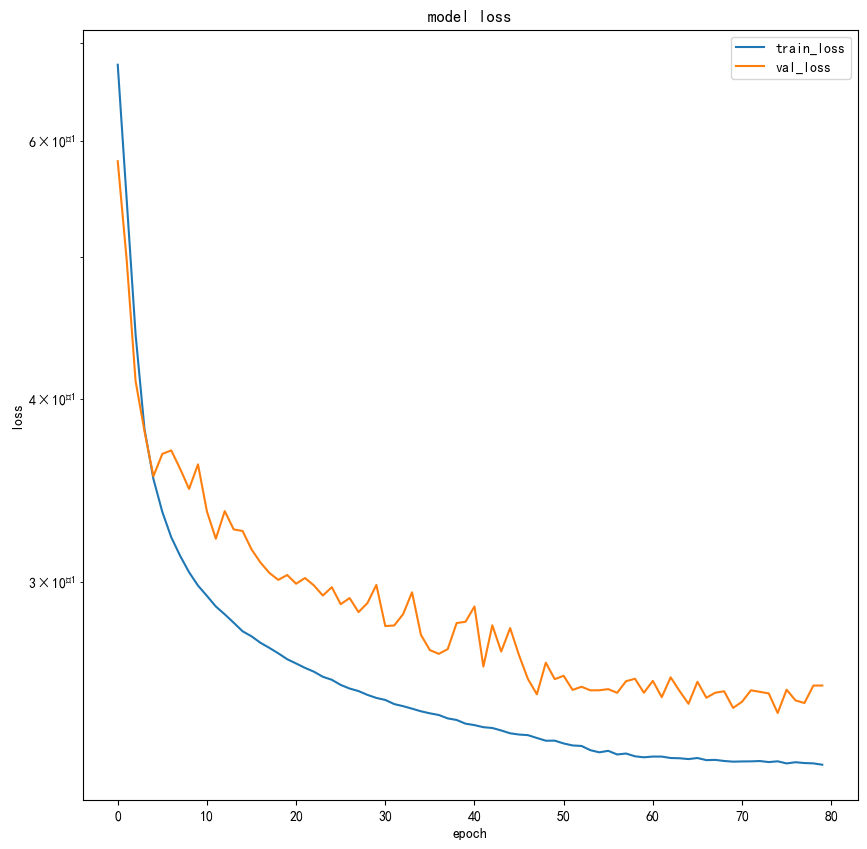

In [17]:
# 这段代码用于可视化模型训练过程中损失值的变化

plt.figure(figsize=(10, 10))   #创建图形对象,设置图形大小为 10x10 英寸
plt.semilogy(eddynet.history.history['loss'])
# 使用 semilogy 函数绘制训练损失（loss）的变化。
# semilogy 使用对数刻度显示 y 轴的值，可以更好地展示损失值的变化

plt.semilogy(eddynet.history.history['val_loss'])
# 使用 semilogy 函数绘制验证损失（val_loss）的变化。

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# 设置图表标题为 "model loss"。
# 设置 y 轴标签为 "loss"。
# 设置 x 轴标签为 "epoch"。

plt.legend(['train_loss', 'val_loss'], loc='upper right');
# 添加图例，说明两条曲线分别表示训练损失和验证损失。
# 将图例放置在右上角（upper right）。




In [18]:
# 从您上传的图表可以看出，训练过程中损失的变化趋势如下：

# 图表分析
# 训练损失和验证损失：
# 蓝色曲线表示训练损失（train_loss）。
# 橙色曲线表示验证损失（val_loss）。
# 在训练的初期，训练损失和验证损失都迅速下降，这表明模型正在学习数据的模式。

# 损失曲线的趋势：
# 随着训练的进行，训练损失和验证损失逐渐趋于平稳，表明模型逐渐收敛。
# 验证损失在某些点有波动，这可能是由于数据的随机性或模型在验证集上的泛化能力的调整。

# 验证损失与训练损失的差距：
# 从图中可以看到，训练损失和验证损失非常接近，这表明模型没有过拟合，训练良好。
# 如果验证损失明显高于训练损失，那可能表明模型过拟合，但在这个图表中未见明显过拟合现象。



# 进一步的分析
# 验证集上的波动：
# 验证损失的波动可能是由于小的批次数据引起的。
# 在这种情况下，可以考虑增加 patience 参数或者 ReduceLROnPlateau 回调函数的 factor 值。

# 训练时间：
# 如果训练时间太长，模型可能会开始过拟合。
# 在这种情况下，早停策略（EarlyStopping 回调）可能有帮助。




# 建议
# 继续观察损失曲线：
# 继续观察训练过程中损失曲线的变化。
# 如果验证损失开始增加而训练损失继续下降，这可能是过拟合的迹象。

# 调整超参数：
# 考虑调整学习率或增加正则化，以防止过拟合。
# 使用 EarlyStopping 回调函数，防止模型在验证损失不再改善时继续训练。




# 总结
# 整体来说，您的模型在训练过程中表现良好。
# 训练和验证损失都在逐渐下降并趋于平稳，表明模型已经基本收敛。
# 继续监控这些指标，并根据需要调整训练参数，以获得更好的性能。



overfitting, huh?... I'm working on that on my next paper, stay tuned! meanwhile for your application you can either get more data or lower the complexity of the architecture (less neurons, less depth..) 

In [16]:
SSH_test = np.expand_dims(np.load(r'D:\jupyterProject\eddy\data\2023\npyData\trainSla_2023_nanhai.npy'),3) #you can use all the region, in here I selected a box of 168*168 size
# np.expand_dims(..., 3)：expand_dims 函数用于在数组中增加一个新的轴。参数 3 表示新轴被添加在原数组的第四个维度（索引从0开始）。这通常用于确保数据的维度与某些特定的数据处理或机器学习模型的输入要求相匹配。
#######
Seg_test = np.expand_dims(np.load(r'D:\jupyterProject\eddy\data\2023\npyData\trainEddy_2023_nanhai.npy'),3)

SSH_test.shape
#####
Seg_test.shape

(365, 88, 80, 1)

(365, 88, 80, 1)

In [17]:
Seg_test_categor = to_categorical(np.reshape(Seg_test[:,:,:,0],(365,88*80)),3)
Seg_test_categor.shape

(365, 7040, 3)

In [18]:
print("Model output shape:", eddynet.output_shape)
print("Labels shape:", Seg_test_categor.shape)

Model output shape: (None, 7040, 3)
Labels shape: (365, 7040, 3)


12/12 [==============================] - 25s 21ms/step - loss: 0.2359 - categorical_accuracy: 0.9303 - dice_coef_anti: 0.7518 - dice_coef_cyc: 0.7533 - dice_coef_nn: 0.9598 - mean_dice_coef: 0.8216 - weighted_mean_dice_coef: 0.7601
loss: 0.2359137088060379
categorical_accuracy: 0.9303000569343567
dice_coef_anti: 0.751810610294342
dice_coef_cyc: 0.7532734870910645
dice_coef_nn: 0.9597588181495667
mean_dice_coef: 0.8216143250465393
weighted_mean_dice_coef: 0.7600834965705872


<Figure size 1200x800 with 0 Axes>

<Axes: >

<Axes: >

<Axes: >

Text(0.5, 1.0, '反气旋涡 Dice 系数')

Text(0, 0.5, 'Dice 系数')

Text(0.5, 0, '训练轮次')

<Axes: >

<Axes: >

<Axes: >

Text(0.5, 1.0, '气旋涡 Dice 系数')

Text(0, 0.5, 'Dice 系数')

Text(0.5, 0, '训练轮次')

<Axes: >

<Axes: >

<Axes: >

Text(0.5, 1.0, '无涡旋区域 Dice 系数')

Text(0, 0.5, 'Dice 系数')

Text(0.5, 0, '训练轮次')

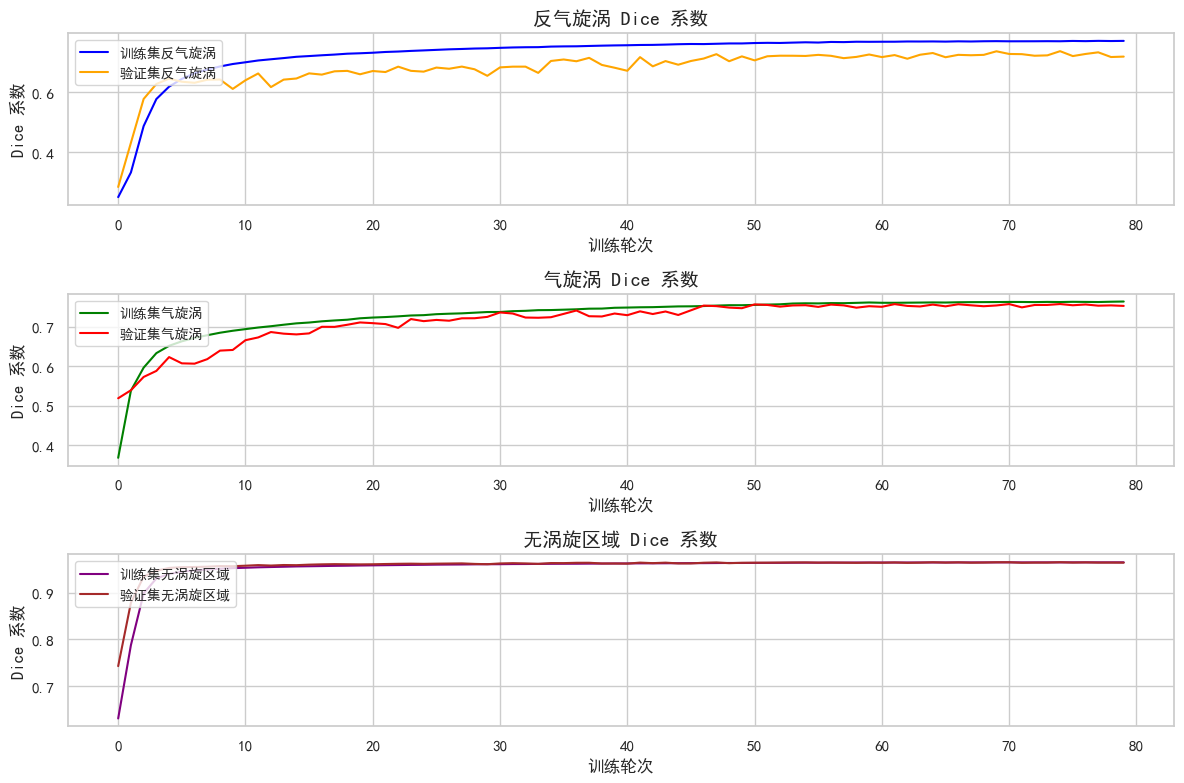

<Figure size 1200x800 with 0 Axes>

<Axes: >

<Axes: >

Text(0.5, 1.0, '分类准确率 (Categorical Accuracy)')

Text(0, 0.5, '准确率')

Text(0.5, 0, '训练轮次')

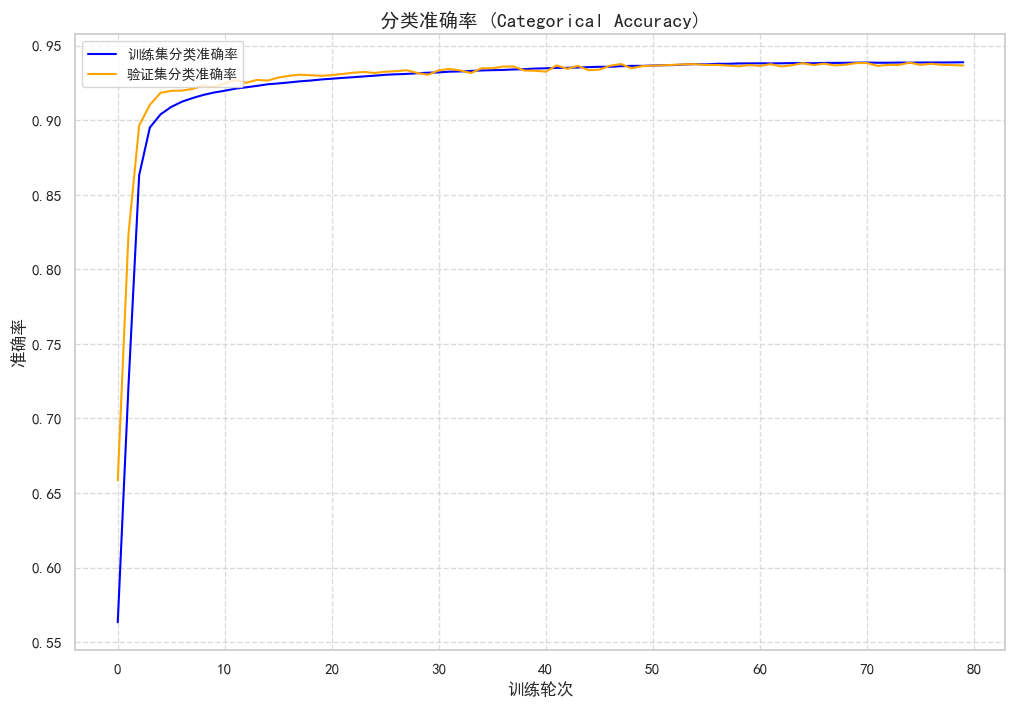

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

eddynet = load_model(r'E:\大创\EddyNet\EddyNet-master\EddyNet_new\weights\eddynet8.keras', 
                     custom_objects={'dice_coef_anti': dice_coef_anti, 
                                     'dice_coef_cyc': dice_coef_cyc, 
                                     'dice_coef_nn': dice_coef_nn,
                                     'mean_dice_coef': mean_dice_coef,
                                     'weighted_mean_dice_coef': weighted_mean_dice_coef,
                                     'dice_coef_loss': dice_coef_loss})  # 确保 categorical_accuracy 被包括在内

# 加载训练历史记录
with open('train_history_eddynet.npy', 'rb') as f:
    histeddynet = np.load(f, allow_pickle=True).item()

# 现在可以直接评估模型
results = eddynet.evaluate(SSH_test, Seg_test_categor)
for name, value in zip(eddynet.metrics_names, results):
    print(f"{name}: {value}")
 




sns.set_theme(style="whitegrid", font="SimHei", palette="muted")  # 中文字体需要系统支持

# 绘制反气旋涡的 Dice 系数
plt.figure(figsize=(12, 8))
plt.subplot(311)
sns.lineplot(x=range(len(histeddynet['dice_coef_anti'])), y=histeddynet['dice_coef_anti'], label='训练集反气旋涡', color='blue')
sns.lineplot(x=range(len(histeddynet['val_dice_coef_anti'])), y=histeddynet['val_dice_coef_anti'], label='验证集反气旋涡', color='orange')
plt.title('反气旋涡 Dice 系数', fontsize=14, fontweight='bold')
plt.ylabel('Dice 系数', fontsize=12)
plt.xlabel('训练轮次', fontsize=12)
plt.legend(fontsize=10, loc='upper left')

# 绘制气旋涡的 Dice 系数
plt.subplot(312)
sns.lineplot(x=range(len(histeddynet['dice_coef_cyc'])), y=histeddynet['dice_coef_cyc'], label='训练集气旋涡', color='green')
sns.lineplot(x=range(len(histeddynet['val_dice_coef_cyc'])), y=histeddynet['val_dice_coef_cyc'], label='验证集气旋涡', color='red')
plt.title('气旋涡 Dice 系数', fontsize=14, fontweight='bold')
plt.ylabel('Dice 系数', fontsize=12)
plt.xlabel('训练轮次', fontsize=12)
plt.legend(fontsize=10, loc='upper left')

# 绘制无涡旋区域的 Dice 系数
plt.subplot(313)
sns.lineplot(x=range(len(histeddynet['dice_coef_nn'])), y=histeddynet['dice_coef_nn'], label='训练集无涡旋区域', color='purple')
sns.lineplot(x=range(len(histeddynet['val_dice_coef_nn'])), y=histeddynet['val_dice_coef_nn'], label='验证集无涡旋区域', color='brown')
plt.title('无涡旋区域 Dice 系数', fontsize=14, fontweight='bold')
plt.ylabel('Dice 系数', fontsize=12)
plt.xlabel('训练轮次', fontsize=12)
plt.legend(fontsize=10, loc='upper left')

plt.tight_layout()  # 自动调整子图间距
plt.show()

# 绘制分类准确率 (categorical accuracy)
plt.figure(figsize=(12, 8))
sns.lineplot(x=range(len(histeddynet['categorical_accuracy'])), y=histeddynet['categorical_accuracy'], label='训练集分类准确率', color='blue')
sns.lineplot(x=range(len(histeddynet['val_categorical_accuracy'])), y=histeddynet['val_categorical_accuracy'], label='验证集分类准确率', color='orange')
plt.title('分类准确率 (Categorical Accuracy)', fontsize=14, fontweight='bold')
plt.ylabel('准确率', fontsize=12)
plt.xlabel('训练轮次', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(linestyle='--', alpha=0.7)  # 添加网格线
plt.show()




In [17]:
import plotly.graph_objects as go

# 假设 histeddynet 包含损失值数据
# 示例数据
epochs = list(range(1, len(histeddynet['loss']) + 1))

# 创建训练损失的折线图
train_loss_trace = go.Scatter(
    x=epochs,
    y=histeddynet['loss'],
    mode='lines+markers',
    name='Train Loss',
    line=dict(color='blue'),
    marker=dict(size=8)
)

# 创建验证损失的折线图
val_loss_trace = go.Scatter(
    x=epochs,
    y=histeddynet['val_loss'],
    mode='lines+markers',
    name='Validation Loss',
    line=dict(color='red'),
    marker=dict(size=8)
)

# 创建图形对象
fig = go.Figure()

# 添加数据到图形中
fig.add_trace(train_loss_trace)
fig.add_trace(val_loss_trace)

# 设置图表标题和坐标轴标签
fig.update_layout(
    title='Model Loss',
    xaxis=dict(
        title='Epoch',
        tickmode='linear',
        tickfont=dict(size=16),
        titlefont=dict(size=18)
    ),
    yaxis=dict(
        title='Loss',
        type='log',  # 设置 y 轴为对数刻度
        tickfont=dict(size=16),
        titlefont=dict(size=18),
        showexponent='none'  # 取消科学计数法显示
    ),
    font=dict(
        family='Times New Roman',
        size=20
    ),
    legend=dict(
        title=None,
        font=dict(size=14),
        x=0.8,
        y=1.0
    ),
    width=800,
    height=600
)

# 显示图表
fig.show()



<Figure size 1200x800 with 0 Axes>

<Axes: xlabel='Epoch', ylabel='Loss'>

Text(0.5, 1.0, 'Model Loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

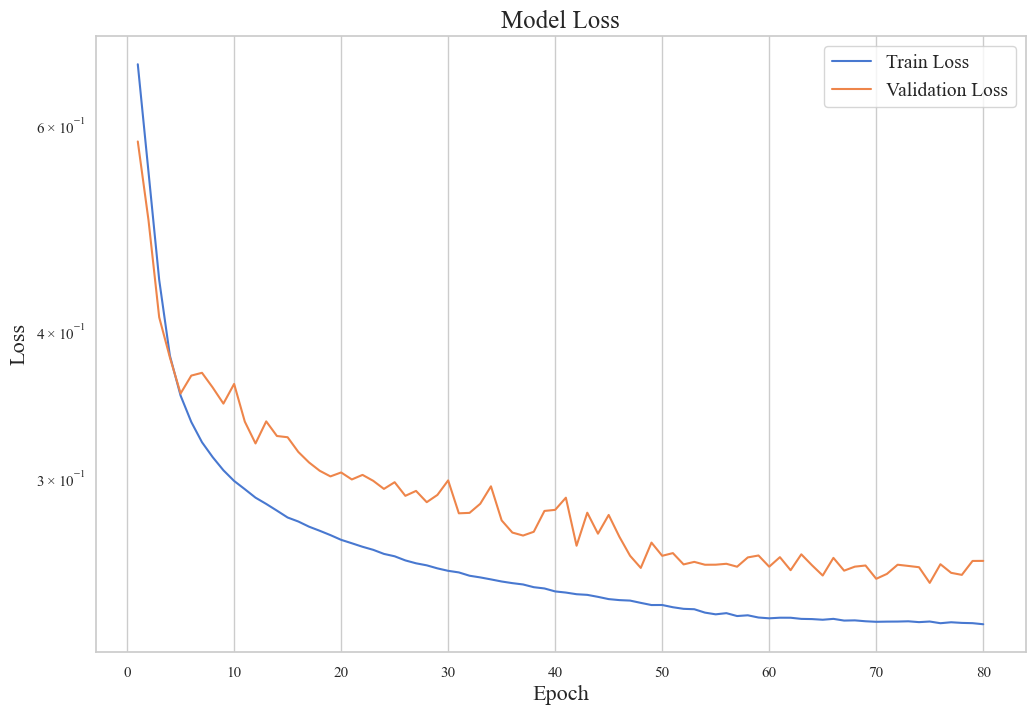

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 设置字体为 Times New Roman
plt.rcParams.update({
    'font.size': 20,
    'font.family': 'Times New Roman'
})

# 自定义格式化函数，将科学计数法转换为普通数字
def format_func(value, tick_number):
    return f'{value:.0f}'


epochs = list(range(1, len(histeddynet['loss']) + 1))

# 创建 DataFrame 以便于使用 seaborn
import pandas as pd
data = pd.DataFrame({
    'Epoch': epochs + epochs,
    'Loss': histeddynet['loss'] + histeddynet['val_loss'],
    'Type': ['Train Loss'] * len(histeddynet['loss']) + ['Validation Loss'] * len(histeddynet['val_loss'])
})

# 绘图
plt.figure(figsize=(12, 8))
sns.lineplot(data=data, x='Epoch', y='Loss', hue='Type')

# 设置对数刻度
plt.yscale('log')

# 设置图表标题、轴标签和图例
plt.title('Model Loss', fontsize=18)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)

# 设置纵坐标格式
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(format_func))

# 设置图例
plt.legend(loc='upper right', fontsize=14)

# 显示图表
plt.show()

<Figure size 1200x800 with 0 Axes>

Text(0.5, 1.0, 'Model Loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

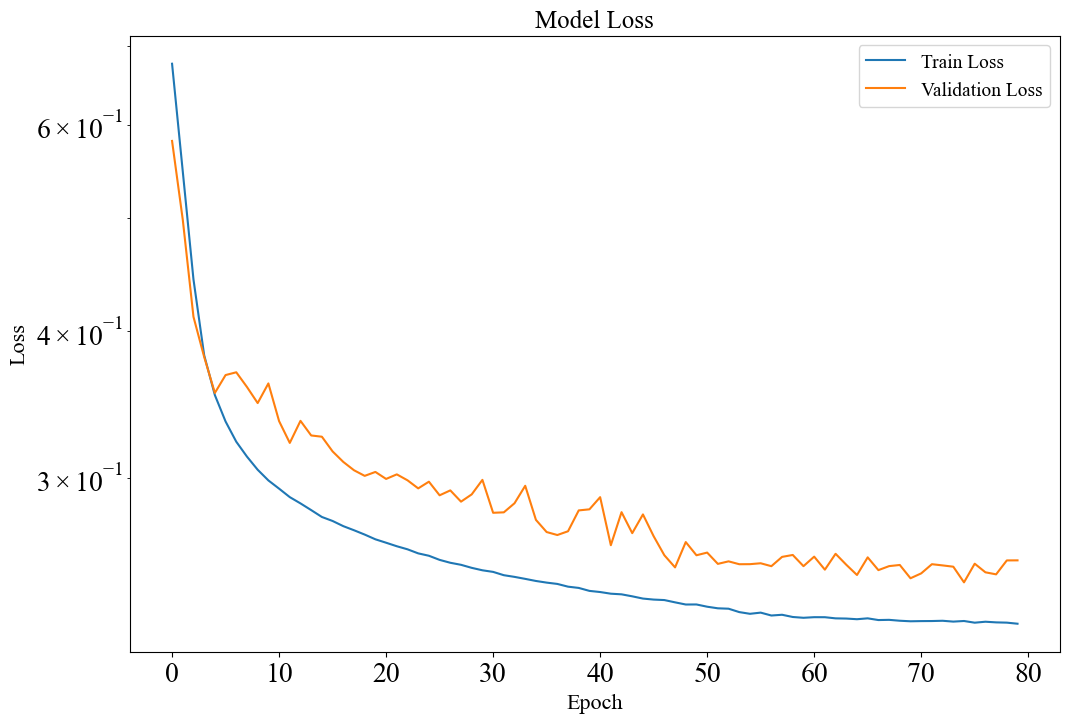

In [22]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 设置字体为 Times New Roman
plt.rcParams.update({
    'font.size': 20,
    'font.family': 'Times New Roman'
})

# 自定义格式化函数，将科学计数法转换为普通数字
def format_func(value, tick_number):
    return f'{value:.0f}'

# 绘制模型训练过程中损失值的变化
plt.figure(figsize=(12, 8))  # 创建图形对象, 设置图形大小为 12x8 英寸

# 使用 semilogy 函数绘制训练损失（loss）的变化
plt.semilogy(histeddynet['loss'], label='Train Loss')

# 使用 semilogy 函数绘制验证损失（val_loss）的变化
plt.semilogy(histeddynet['val_loss'], label='Validation Loss')

# 设置图表标题、y 轴标签和 x 轴标签
plt.title('Model Loss', fontsize=18)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)

# 设置纵坐标格式
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(format_func))

# 添加图例，说明两条曲线分别表示训练损失和验证损失，并将图例放置在右上角
plt.legend(loc='upper right', fontsize=14)

# 显示图表
plt.show()


In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 预测结果
predictions = eddynet.predict(SSH_test)
predictions = np.argmax(predictions, axis=-1).reshape(-1)

# 真实标签
true_labels = np.argmax(Seg_test_categor, axis=-1).reshape(-1)

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predictions)

# 打印混淆矩阵
print("Confusion Matrix:")
print(cm)

# 计算分类报告
report = classification_report(true_labels, predictions, target_names=['No Eddy', 'Cyclonic Eddy', 'Anticyclonic Eddy'])
print("Classification Report:")
print(report)


12/12 [==============================] - 1s 31ms/step
Confusion Matrix:
[[2104095   40949   33618]
 [  41847  138579       0]
 [  62687       0  147825]]
Classification Report:
                   precision    recall  f1-score   support

          No Eddy       0.95      0.97      0.96   2178662
    Cyclonic Eddy       0.77      0.77      0.77    180426
Anticyclonic Eddy       0.81      0.70      0.75    210512

         accuracy                           0.93   2569600
        macro avg       0.85      0.81      0.83   2569600
     weighted avg       0.93      0.93      0.93   2569600



## Performance on train dataset 
just to be sure...

1/1 [==============================] - 1s 672ms/step


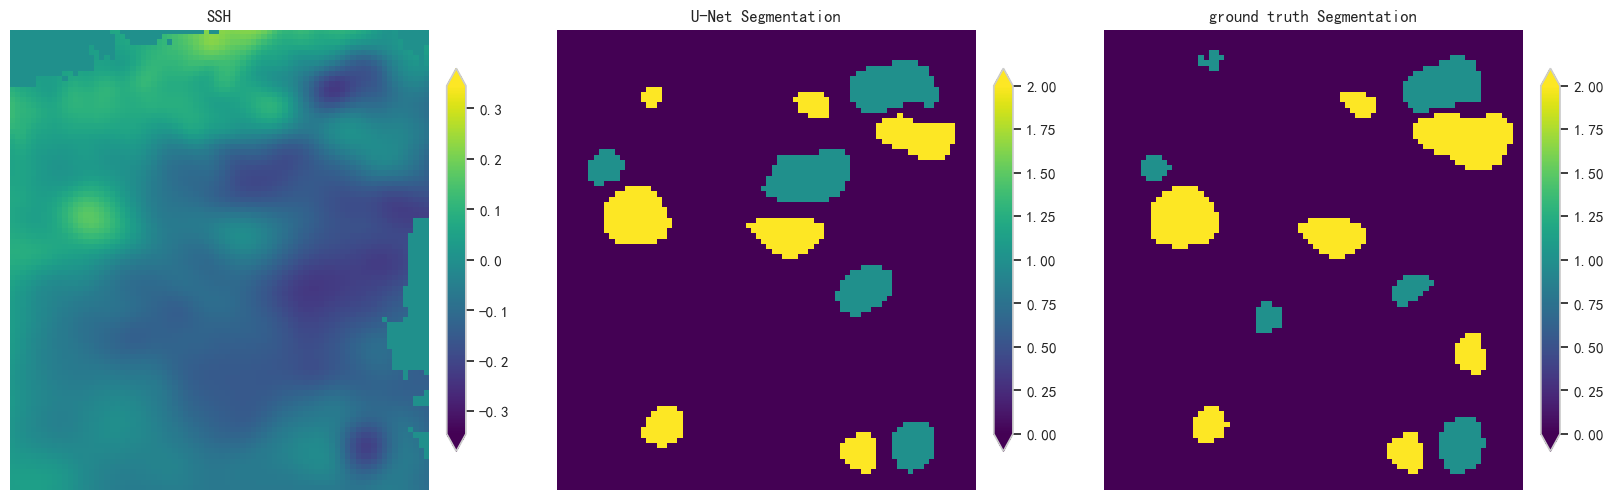

In [20]:
randindex=np.random.randint(0,len(SSH_train))
predictedSEGM=eddynet.predict(np.reshape(SSH_train[randindex,:,:],(1,height,width,1)))
predictedSEGMimage = np.reshape(predictedSEGM.argmax(2),(height,width))

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(SSH_train[randindex,:,:,0], cmap='viridis',vmin=-0.345, vmax=0.345)
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(132)
plt.imshow(predictedSEGMimage, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('U-Net Segmentation');

plt.subplot(133)
plt.imshow(Seg_train[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');

## Performance on test dataset (2012data)

In [36]:
mask=np.load('mask_nanhai_2021_ok.npy')

1/1 [==============================] - 0s 46ms/step


<Figure size 3000x2000 with 0 Axes>

([<matplotlib.axis.XTick at 0x1d8d7ab7f50>,
 [Text(0.0, 0, '100.0'),
  Text(23.75, 0, '106.0'),
  Text(47.5, 0, '112.0'),
  Text(71.25, 0, '118.0'),
  Text(95.0, 0, '124.0')])

([<matplotlib.axis.YTick at 0x1d8d4b4dd90>,
 [Text(0, 0.0, '24.0'),
  Text(0, 23.75, '18.0'),
  Text(0, 47.5, '12.0'),
  Text(0, 71.25, '6.0'),
  Text(0, 95.0, '0.0')])

Text(0.5, 0, '经度')

Text(0, 0.5, '纬度')

Text(0.5, 1.0, 'Eddynet Segmentation')

D:\python_jupyter\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 32428 (\N{CJK UNIFIED IDEOGRAPH-7EAC}) missing from current font.
  func(*args, **kwargs)
D:\python_jupyter\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  func(*args, **kwargs)
D:\python_jupyter\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 32463 (\N{CJK UNIFIED IDEOGRAPH-7ECF}) missing from current font.
  func(*args, **kwargs)
D:\python_jupyter\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32428 (\N{CJK UNIFIED IDEOGRAPH-7EAC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python_jupyter\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python_jupyter\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32463 (

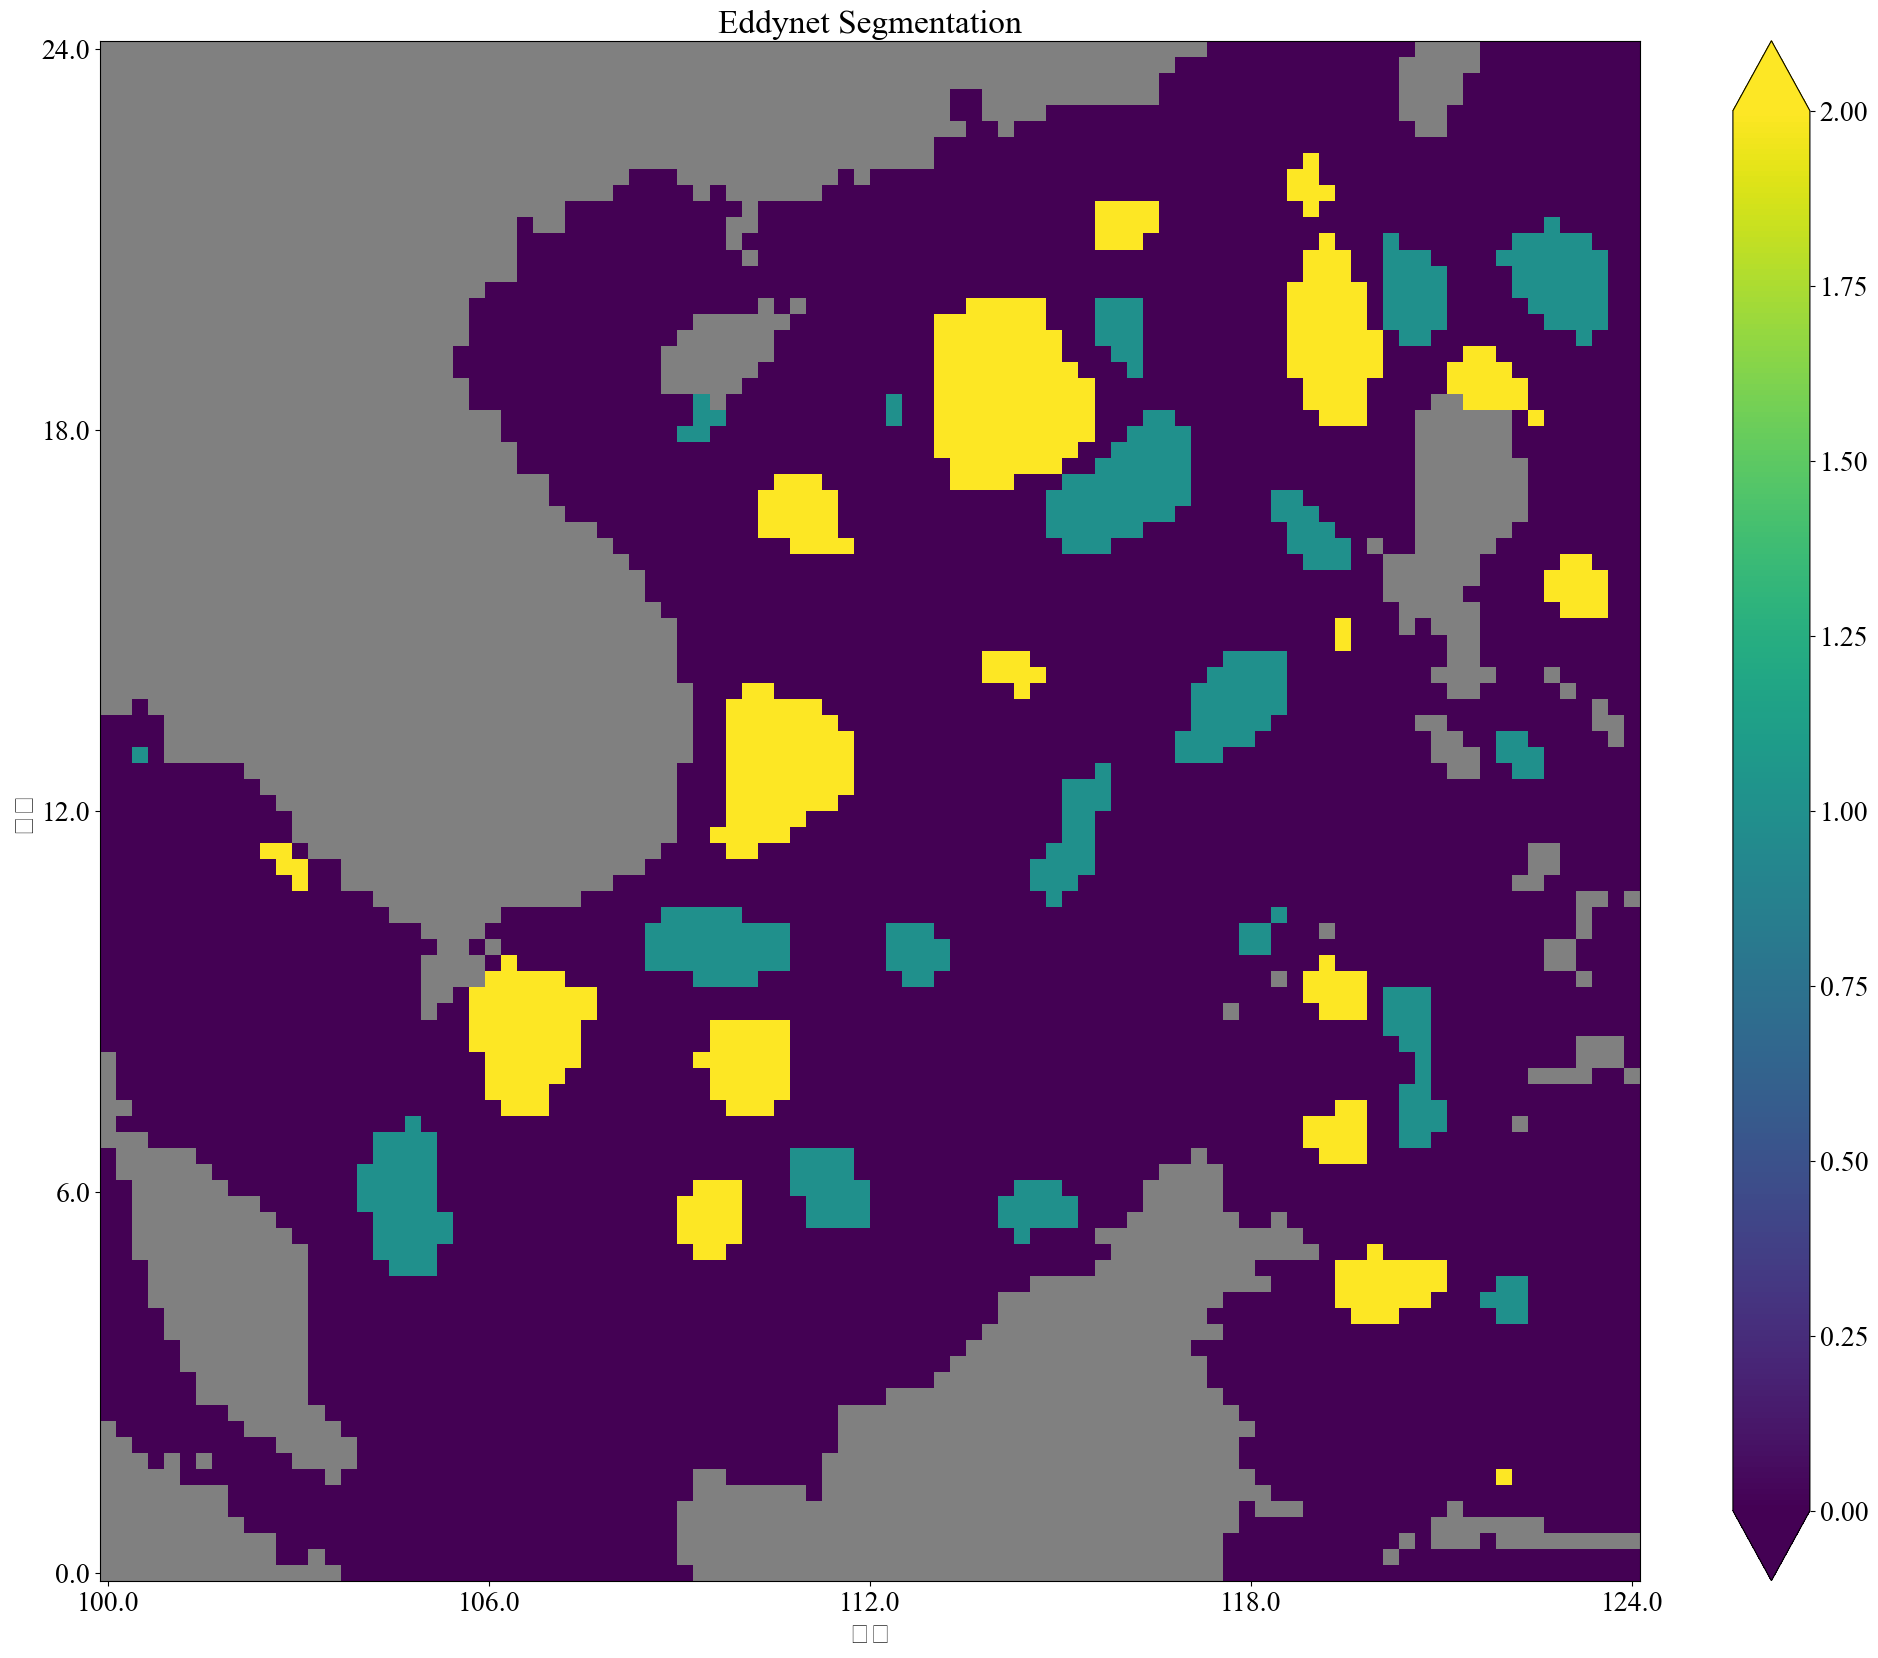

In [37]:
# 五月1日
randindex=np.random.randint(0,len(SSH_test))
# randindex=121
predictedSEGM=eddynet.predict(np.reshape(SSH_test[randindex,:,:],(1,height,width,1)))
predictedSEGMimage = np.reshape(predictedSEGM.argmax(2),(height,width))

alphaData=mask[randindex,:,:]
cmap_gray = mcolors.ListedColormap(['white', 'gray'])

# 自定义的经度和纬度范围
longitudes = np.linspace(100, 124, SSH_test.shape[1])
latitudes = np.linspace(24, 0, SSH_test.shape[2])

plt.figure(figsize=(30, 20))

plt.imshow(predictedSEGMimage, cmap='viridis', vmin=0, vmax=2)
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
plt.imshow(mask[randindex, :, :], cmap=cmap_gray, alpha=alphaData)  # 叠加灰色不透明掩膜
plt.xticks(ticks=np.linspace(0, SSH_test.shape[1] - 1, 5), labels=np.linspace(100, 124, 5))
plt.yticks(ticks=np.linspace(0, SSH_test.shape[2] - 1, 5), labels=np.linspace(24, 0, 5))
plt.xlabel('经度')
plt.ylabel('纬度')
plt.title('Eddynet Segmentation')




<Figure size 2000x2000 with 0 Axes>

<Axes: >

1/1 [==============================] - 0s 46ms/step


([<matplotlib.axis.XTick at 0x1d8d7b7d210>,
 [Text(0.0, 0, '100.0'),
  Text(23.75, 0, '106.0'),
  Text(47.5, 0, '112.0'),
  Text(71.25, 0, '118.0'),
  Text(95.0, 0, '124.0')])

([<matplotlib.axis.YTick at 0x1d8d7b9da90>,
 [Text(0, 0.0, '24.0'),
  Text(0, 23.75, '18.0'),
  Text(0, 47.5, '12.0'),
  Text(0, 71.25, '6.0'),
  Text(0, 95.0, '0.0')])

Text(0.5, 0, '经度')

Text(0, 0.5, '纬度')

Text(0.5, 1.0, 'Month 1')

<Axes: >

1/1 [==============================] - 0s 47ms/step


([<matplotlib.axis.XTick at 0x1d8d7b29950>,
 [Text(0.0, 0, '100.0'),
  Text(23.75, 0, '106.0'),
  Text(47.5, 0, '112.0'),
  Text(71.25, 0, '118.0'),
  Text(95.0, 0, '124.0')])

([<matplotlib.axis.YTick at 0x1d8d4f96410>,
 [Text(0, 0.0, '24.0'),
  Text(0, 23.75, '18.0'),
  Text(0, 47.5, '12.0'),
  Text(0, 71.25, '6.0'),
  Text(0, 95.0, '0.0')])

Text(0.5, 0, '经度')

Text(0, 0.5, '纬度')

Text(0.5, 1.0, 'Month 2')

<Axes: >

1/1 [==============================] - 0s 47ms/step


([<matplotlib.axis.XTick at 0x1d8d4f8ed90>,
 [Text(0.0, 0, '100.0'),
  Text(23.75, 0, '106.0'),
  Text(47.5, 0, '112.0'),
  Text(71.25, 0, '118.0'),
  Text(95.0, 0, '124.0')])

([<matplotlib.axis.YTick at 0x1d8d4b8a710>,
 [Text(0, 0.0, '24.0'),
  Text(0, 23.75, '18.0'),
  Text(0, 47.5, '12.0'),
  Text(0, 71.25, '6.0'),
  Text(0, 95.0, '0.0')])

Text(0.5, 0, '经度')

Text(0, 0.5, '纬度')

Text(0.5, 1.0, 'Month 3')

<Axes: >

1/1 [==============================] - 0s 47ms/step


([<matplotlib.axis.XTick at 0x1d8d5034650>,
 [Text(0.0, 0, '100.0'),
  Text(23.75, 0, '106.0'),
  Text(47.5, 0, '112.0'),
  Text(71.25, 0, '118.0'),
  Text(95.0, 0, '124.0')])

([<matplotlib.axis.YTick at 0x1d8d503b950>,
 [Text(0, 0.0, '24.0'),
  Text(0, 23.75, '18.0'),
  Text(0, 47.5, '12.0'),
  Text(0, 71.25, '6.0'),
  Text(0, 95.0, '0.0')])

Text(0.5, 0, '经度')

Text(0, 0.5, '纬度')

Text(0.5, 1.0, 'Month 4')

<Axes: >

1/1 [==============================] - 0s 50ms/step


([<matplotlib.axis.XTick at 0x1d8d4ffbc50>,
 [Text(0.0, 0, '100.0'),
  Text(23.75, 0, '106.0'),
  Text(47.5, 0, '112.0'),
  Text(71.25, 0, '118.0'),
  Text(95.0, 0, '124.0')])

([<matplotlib.axis.YTick at 0x1d8d4f79090>,
 [Text(0, 0.0, '24.0'),
  Text(0, 23.75, '18.0'),
  Text(0, 47.5, '12.0'),
  Text(0, 71.25, '6.0'),
  Text(0, 95.0, '0.0')])

Text(0.5, 0, '经度')

Text(0, 0.5, '纬度')

Text(0.5, 1.0, 'Month 5')

<Axes: >

1/1 [==============================] - 0s 50ms/step


([<matplotlib.axis.XTick at 0x1d8d50aa190>,
 [Text(0.0, 0, '100.0'),
  Text(23.75, 0, '106.0'),
  Text(47.5, 0, '112.0'),
  Text(71.25, 0, '118.0'),
  Text(95.0, 0, '124.0')])

([<matplotlib.axis.YTick at 0x1d8d4bf1110>,
 [Text(0, 0.0, '24.0'),
  Text(0, 23.75, '18.0'),
  Text(0, 47.5, '12.0'),
  Text(0, 71.25, '6.0'),
  Text(0, 95.0, '0.0')])

Text(0.5, 0, '经度')

Text(0, 0.5, '纬度')

Text(0.5, 1.0, 'Month 6')

<Axes: >

1/1 [==============================] - 0s 49ms/step


([<matplotlib.axis.XTick at 0x1d8d50fdc50>,
 [Text(0.0, 0, '100.0'),
  Text(23.75, 0, '106.0'),
  Text(47.5, 0, '112.0'),
  Text(71.25, 0, '118.0'),
  Text(95.0, 0, '124.0')])

([<matplotlib.axis.YTick at 0x1d8d50e7a90>,
 [Text(0, 0.0, '24.0'),
  Text(0, 23.75, '18.0'),
  Text(0, 47.5, '12.0'),
  Text(0, 71.25, '6.0'),
  Text(0, 95.0, '0.0')])

Text(0.5, 0, '经度')

Text(0, 0.5, '纬度')

Text(0.5, 1.0, 'Month 7')

<Axes: >

1/1 [==============================] - 0s 65ms/step


([<matplotlib.axis.XTick at 0x1d8d3b3c890>,
 [Text(0.0, 0, '100.0'),
  Text(23.75, 0, '106.0'),
  Text(47.5, 0, '112.0'),
  Text(71.25, 0, '118.0'),
  Text(95.0, 0, '124.0')])

([<matplotlib.axis.YTick at 0x1d8d4bee090>,
 [Text(0, 0.0, '24.0'),
  Text(0, 23.75, '18.0'),
  Text(0, 47.5, '12.0'),
  Text(0, 71.25, '6.0'),
  Text(0, 95.0, '0.0')])

Text(0.5, 0, '经度')

Text(0, 0.5, '纬度')

Text(0.5, 1.0, 'Month 8')

<Axes: >

1/1 [==============================] - 0s 49ms/step


([<matplotlib.axis.XTick at 0x1d8d4b81dd0>,
 [Text(0.0, 0, '100.0'),
  Text(23.75, 0, '106.0'),
  Text(47.5, 0, '112.0'),
  Text(71.25, 0, '118.0'),
  Text(95.0, 0, '124.0')])

([<matplotlib.axis.YTick at 0x1d8d50f3610>,
 [Text(0, 0.0, '24.0'),
  Text(0, 23.75, '18.0'),
  Text(0, 47.5, '12.0'),
  Text(0, 71.25, '6.0'),
  Text(0, 95.0, '0.0')])

Text(0.5, 0, '经度')

Text(0, 0.5, '纬度')

Text(0.5, 1.0, 'Month 9')

<Axes: >

1/1 [==============================] - 0s 47ms/step


([<matplotlib.axis.XTick at 0x1d8d4bffc90>,
 [Text(0.0, 0, '100.0'),
  Text(23.75, 0, '106.0'),
  Text(47.5, 0, '112.0'),
  Text(71.25, 0, '118.0'),
  Text(95.0, 0, '124.0')])

([<matplotlib.axis.YTick at 0x1d8d4b6b690>,
 [Text(0, 0.0, '24.0'),
  Text(0, 23.75, '18.0'),
  Text(0, 47.5, '12.0'),
  Text(0, 71.25, '6.0'),
  Text(0, 95.0, '0.0')])

Text(0.5, 0, '经度')

Text(0, 0.5, '纬度')

Text(0.5, 1.0, 'Month 10')

<Axes: >

1/1 [==============================] - 0s 48ms/step


([<matplotlib.axis.XTick at 0x1d8d4fb1d10>,
 [Text(0.0, 0, '100.0'),
  Text(23.75, 0, '106.0'),
  Text(47.5, 0, '112.0'),
  Text(71.25, 0, '118.0'),
  Text(95.0, 0, '124.0')])

([<matplotlib.axis.YTick at 0x1d8d505c510>,
 [Text(0, 0.0, '24.0'),
  Text(0, 23.75, '18.0'),
  Text(0, 47.5, '12.0'),
  Text(0, 71.25, '6.0'),
  Text(0, 95.0, '0.0')])

Text(0.5, 0, '经度')

Text(0, 0.5, '纬度')

Text(0.5, 1.0, 'Month 11')

<Axes: >

1/1 [==============================] - 0s 38ms/step


([<matplotlib.axis.XTick at 0x1d8d3adc190>,
 [Text(0.0, 0, '100.0'),
  Text(23.75, 0, '106.0'),
  Text(47.5, 0, '112.0'),
  Text(71.25, 0, '118.0'),
  Text(95.0, 0, '124.0')])

([<matplotlib.axis.YTick at 0x1d8d4b909d0>,
 [Text(0, 0.0, '24.0'),
  Text(0, 23.75, '18.0'),
  Text(0, 47.5, '12.0'),
  Text(0, 71.25, '6.0'),
  Text(0, 95.0, '0.0')])

Text(0.5, 0, '经度')

Text(0, 0.5, '纬度')

Text(0.5, 1.0, 'Month 12')

D:\python_jupyter\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 21453 (\N{CJK UNIFIED IDEOGRAPH-53CD}) missing from current font.
  func(*args, **kwargs)
D:\python_jupyter\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 27668 (\N{CJK UNIFIED IDEOGRAPH-6C14}) missing from current font.
  func(*args, **kwargs)
D:\python_jupyter\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26059 (\N{CJK UNIFIED IDEOGRAPH-65CB}) missing from current font.
  func(*args, **kwargs)
D:\python_jupyter\Lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 28065 (\N{CJK UNIFIED IDEOGRAPH-6DA1}) missing from current font.
  func(*args, **kwargs)
D:\python_jupyter\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21453 (\N{CJK UNIFIED IDEOGRAPH-53CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python_jupyter\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27668 (\N{CJK UNIFIED IDEOGRAP

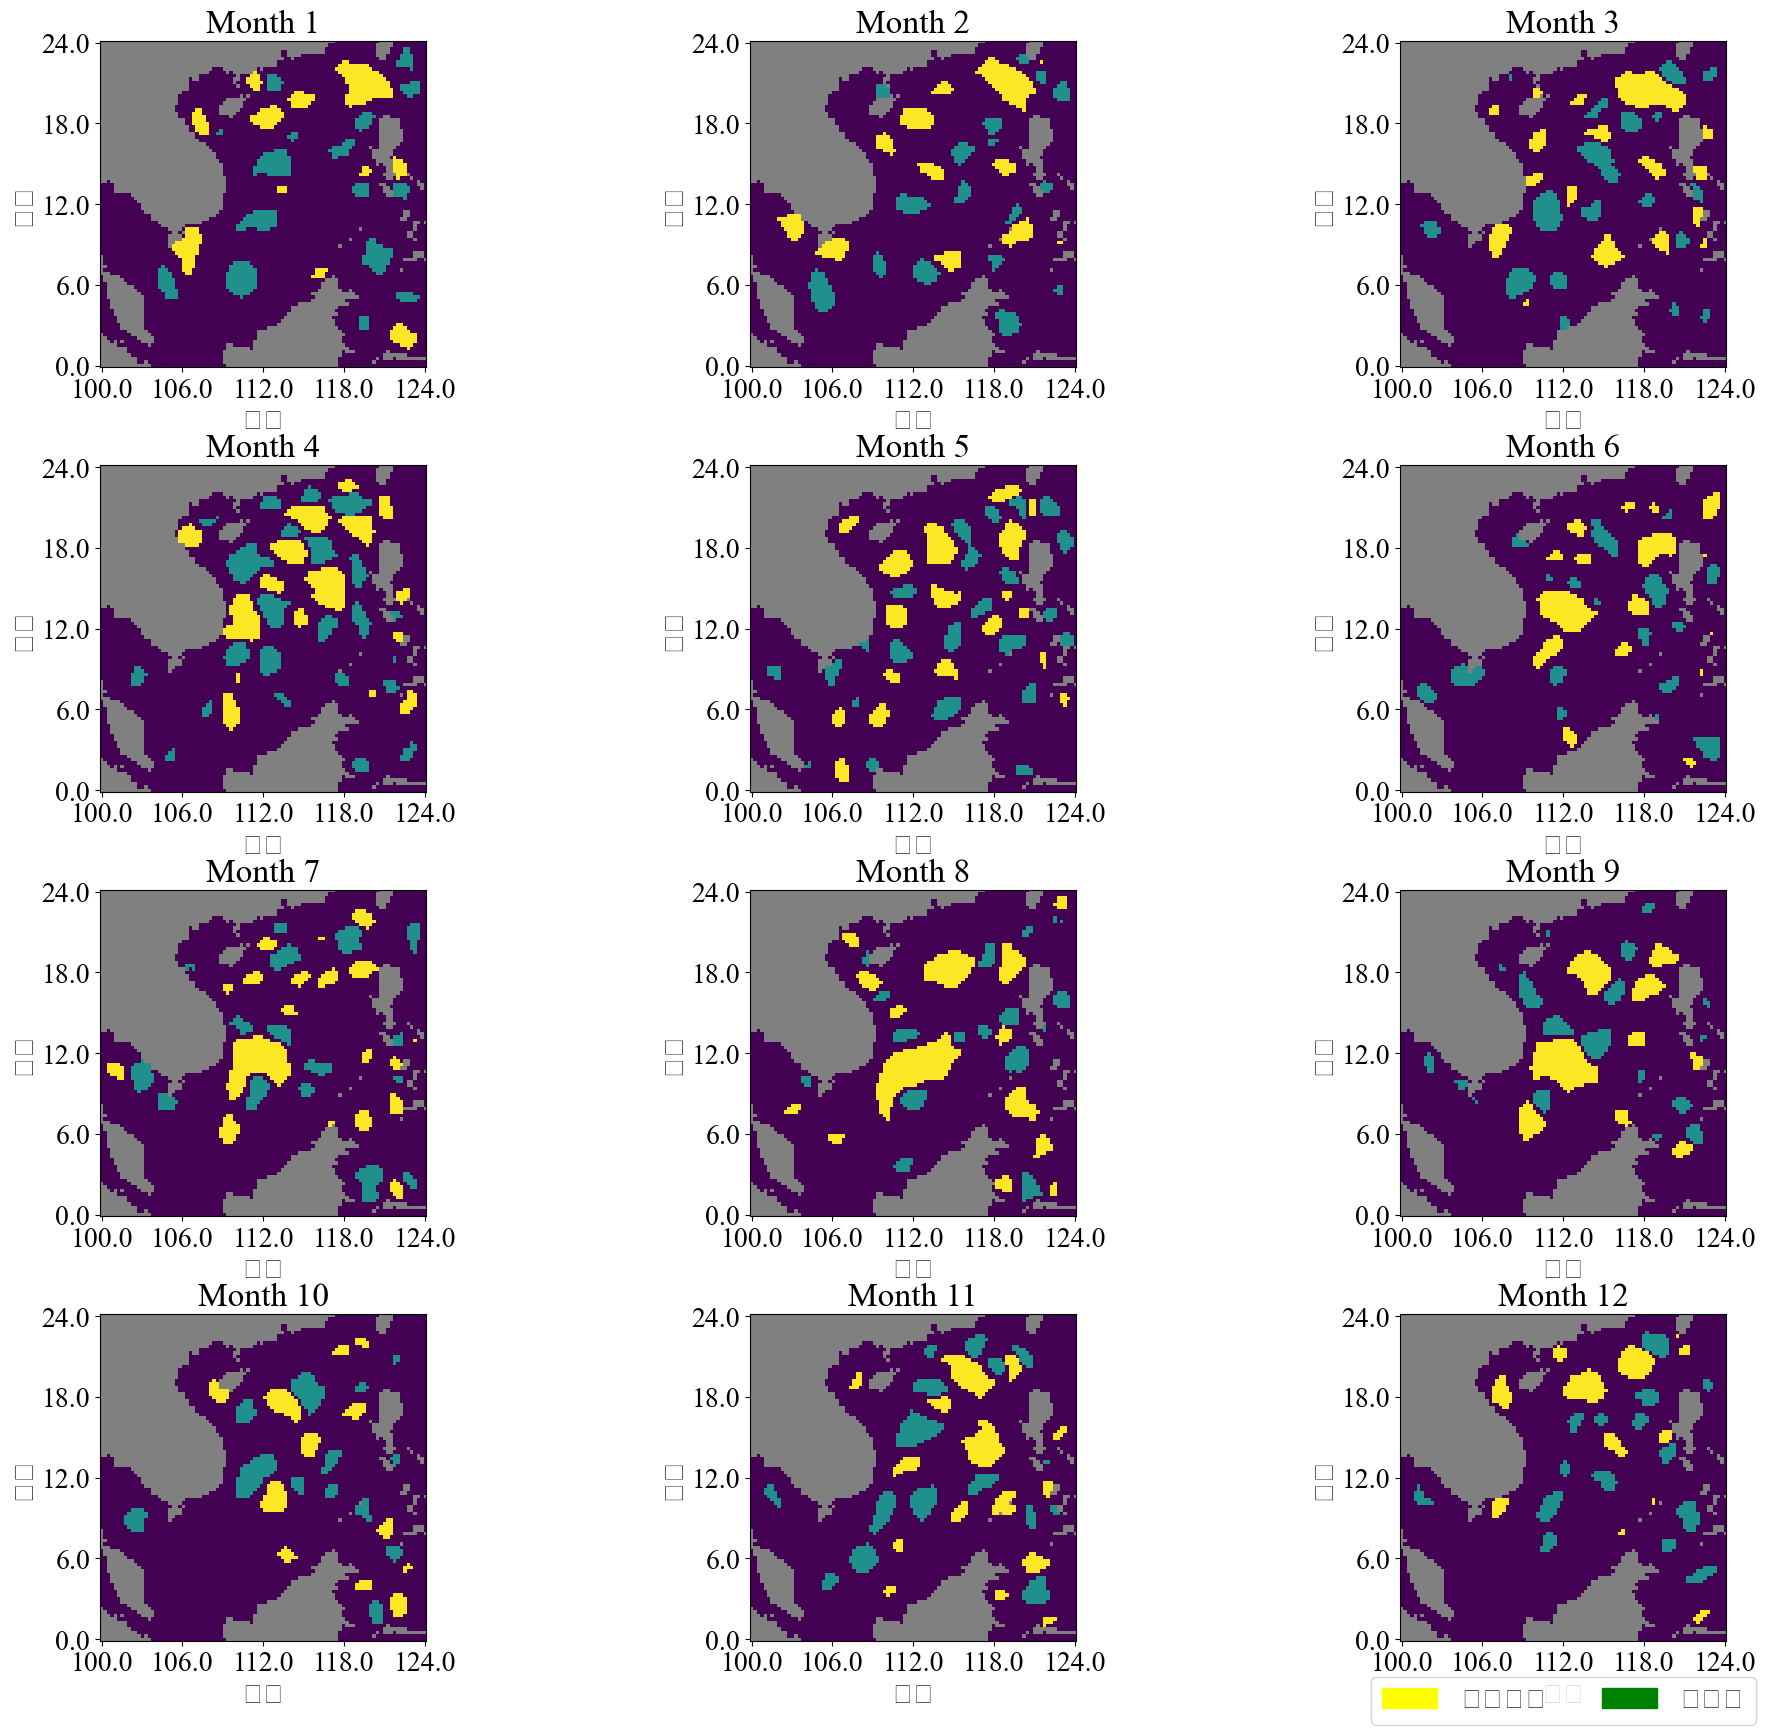

In [38]:
# 每月第一天

# 自定义的经度和纬度范围
longitudes = np.linspace(100, 124, SSH_test.shape[1])
latitudes = np.linspace(24, 0, SSH_test.shape[2])


cmap_gray = mcolors.ListedColormap(['white', 'gray'])
# 每月第一天
months_first_days = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]  # 每个月第一天的索引
months_second_days = [day +19 for day in months_first_days]

plt.figure(figsize=(20, 20))

for i, day in enumerate(months_second_days):
    plt.subplot(4, 3, i + 1)
    predictedSEGM = eddynet.predict(np.reshape(SSH_test[day, :, :], (1, height, width, 1)))
    predictedSEGMimage = np.reshape(predictedSEGM.argmax(2), (height, width))
    alphaData = mask[day, :, :]
    plt.imshow(predictedSEGMimage, cmap='viridis', vmin=0, vmax=2)
#     plt.imshow(Seg_test[day,:,:,0], cmap='viridis', vmin=0, vmax=2)
    plt.imshow(mask[day, :, :], cmap=cmap_gray, alpha=alphaData)  # 添加灰色不透明掩膜
    plt.xticks(ticks=np.linspace(0, SSH_test.shape[1] - 1, 5), labels=np.linspace(100, 124, 5))
    plt.yticks(ticks=np.linspace(0, SSH_test.shape[2] - 1, 5), labels=np.linspace(24, 0, 5))
    plt.xlabel('经度')
    plt.ylabel('纬度')
    plt.title(f'Month {i + 1}')

# 调整子图之间的间距
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.3)

# 添加自定义图例
yellow_patch = mpatches.Patch(color='yellow', label='反气旋涡')
green_patch = mpatches.Patch(color='green', label='气旋涡')
plt.legend(handles=[yellow_patch, green_patch], loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)



Seems working nicely, but there are some false eddy detections that need to be dealt with, working on it..

# 统计分析

In [39]:
SSH_test.shape
#####
Seg_test.shape
mask.shape


(365, 96, 96, 1)

(365, 96, 96, 1)

(365, 96, 96)

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 37ms/step
1月: 气旋涡平均数量 = 14.13, 反气旋涡平均数量 = 11.32
2月: 气旋涡平均数量 = 15.71, 反气旋涡平均数量 = 14.39
3月: 气旋涡平均数量 = 19.48, 反气旋涡平均数量 = 17.32
4月: 气旋涡平均数量 = 21.90, 反气旋涡平均数量 = 16.97
5月: 气旋涡平均数量 = 22.16, 反气旋涡平均数量 = 16.81
6月: 气旋涡平均数量 = 17.83, 反气旋涡平均数量 = 15.00
7月: 气旋涡平均数量 = 14.29, 反气旋涡平均数量 = 15.97
8月: 气旋涡平均数量 = 17.97, 反气旋涡平均数量 = 14.65
9月: 气旋涡平均数量 = 18.43, 反气旋涡平均数量 = 13.57
10月: 气旋涡平均数量 = 19.55, 反气旋涡平均数量 = 14.84
11月: 气旋涡平均数量 = 17.60, 反气旋涡平均数量 = 12.93
12月: 气旋涡平均数量 = 15.03, 反气旋涡平均数量 = 12.94


<Figure size 1200x600 with 0 Axes>

<BarContainer object of 12 artists>

<BarContainer object of 12 artists>

<BarContainer object of 12 artists>

Text(0.5, 0, '月份')

Text(0, 0.5, '平均涡数量')

([<matplotlib.axis.XTick at 0x1d8a916ca90>,
 [Text(0.25, 0, '1月'),
  Text(1.25, 0, '2月'),
  Text(2.25, 0, '3月'),
  Text(3.25, 0, '4月'),
  Text(4.25, 0, '5月'),
  Text(5.25, 0, '6月'),
  Text(6.25, 0, '7月'),
  Text(7.25, 0, '8月'),
  Text(8.25, 0, '9月'),
  Text(9.25, 0, '10月'),
  Text(10.25, 0, '11月'),
  Text(11.25, 0, '12月')])

D:\python_jupyter\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python_jupyter\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python_jupyter\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python_jupyter\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python_jupyter\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python_jupyter\Lib\sit

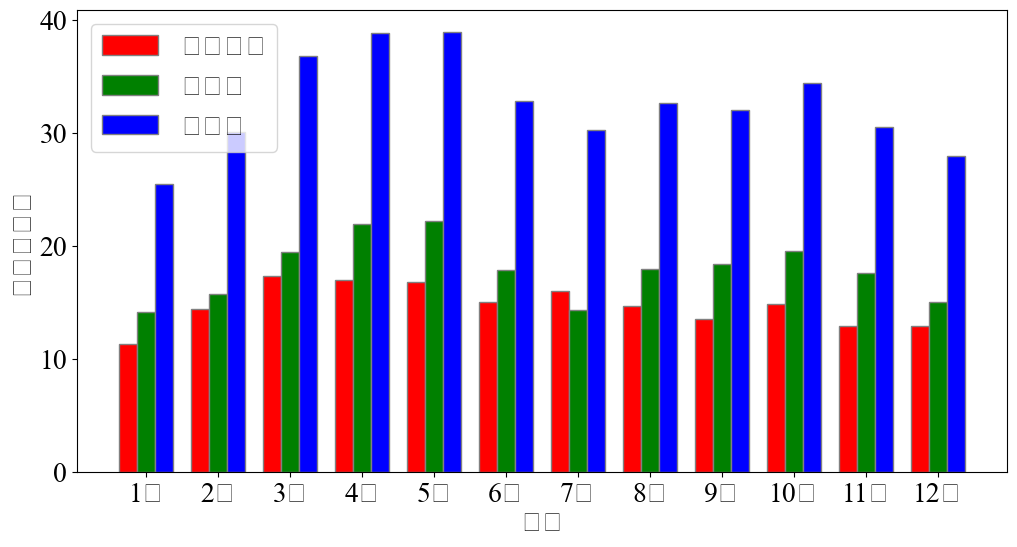

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from scipy.ndimage import label

# 确保 mask 的数据类型为 float32
mask = mask.astype(np.float32)

# 加载模型
eddynet = load_model(r'D:\EddyNet\EddyNet-master\EddyNet_new\weights\eddynet8.h5', 
                     custom_objects={'dice_coef_anti': dice_coef_anti, 
                                     'dice_coef_cyc': dice_coef_cyc, 
                                     'dice_coef_nn': dice_coef_nn,
                                     'mean_dice_coef': mean_dice_coef,
                                     'weighted_mean_dice_coef': weighted_mean_dice_coef,
                                     'dice_coef_loss': dice_coef_loss})

# 定义每个月的索引范围
months_ranges = [
    (0, 30),    # 1月
    (31, 58),   # 2月
    (59, 89),   # 3月
    (90, 119),  # 4月
    (120, 150), # 5月
    (151, 180), # 6月
    (181, 211), # 7月
    (212, 242), # 8月
    (243, 272), # 9月
    (273, 303), # 10月
    (304, 333), # 11月
    (334, 364)  # 12月
]

# 用于统计涡数量的列表
cyclonic_avg_per_month = []
anticyclonic_avg_per_month = []
total_avg_per_month = []

# 遍历每个月
for start_day, end_day in months_ranges:
    cyclonic_counts = []
    anticyclonic_counts = []
    
    for day in range(start_day, end_day + 1):
        predictedSEGM = eddynet.predict(np.reshape(SSH_test[day, :, :], (1, SSH_test.shape[1], SSH_test.shape[2], 1)))
        predictedSEGMimage = np.reshape(predictedSEGM.argmax(2), (SSH_test.shape[1], SSH_test.shape[2]))
        
        # 连通区域分析
        labeled_cyclonic, num_cyclonic = label(predictedSEGMimage == 1)
        labeled_anticyclonic, num_anticyclonic = label(predictedSEGMimage == 2)
        
        cyclonic_counts.append(num_cyclonic)
        anticyclonic_counts.append(num_anticyclonic)
    
    # 计算每个月的平均涡旋数量
    avg_cyclonic = np.mean(cyclonic_counts)
    avg_anticyclonic = np.mean(anticyclonic_counts)
    avg_total = avg_cyclonic + avg_anticyclonic
    
    cyclonic_avg_per_month.append(avg_cyclonic)
    anticyclonic_avg_per_month.append(avg_anticyclonic)
    total_avg_per_month.append(avg_total)

# 打印每个月的气旋涡和反气旋涡的平均数量
for i, month in enumerate(['1月', '2月', '3月', '4月', '5月', '6月', '7月', '8月', '9月', '10月', '11月', '12月']):
    print(f"{month}: 气旋涡平均数量 = {cyclonic_avg_per_month[i]:.2f}, 反气旋涡平均数量 = {anticyclonic_avg_per_month[i]:.2f}")

# 绘制柱状图
months = ['1月', '2月', '3月', '4月', '5月', '6月', '7月', '8月', '9月', '10月', '11月', '12月']
bar_width = 0.25

plt.figure(figsize=(12, 6))
r1 = np.arange(len(months))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.bar(r1, anticyclonic_avg_per_month, color='red', width=bar_width, edgecolor='grey', label='反气旋涡')
plt.bar(r2, cyclonic_avg_per_month, color='green', width=bar_width, edgecolor='grey', label='气旋涡')
plt.bar(r3, total_avg_per_month, color='blue', width=bar_width, edgecolor='grey', label='总涡涡')

plt.xlabel('月份', fontweight='bold')
plt.ylabel('平均涡数量', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(months))], months)
plt.legend()

plt.show()


In [42]:
# 定义每个季度的月份
spring_months = [2, 3, 4]  # 3-5月
summer_months = [5, 6, 7]  # 6-8月
autumn_months = [8, 9, 10]  # 9-11月
winter_months = [11, 0, 1]  # 12月-2月

# 计算每个季度的平均涡旋数量
def calculate_seasonal_averages(monthly_averages, months):
    return np.mean([monthly_averages[month] for month in months])

spring_cyclonic_avg = calculate_seasonal_averages(cyclonic_avg_per_month, spring_months)
summer_cyclonic_avg = calculate_seasonal_averages(cyclonic_avg_per_month, summer_months)
autumn_cyclonic_avg = calculate_seasonal_averages(cyclonic_avg_per_month, autumn_months)
winter_cyclonic_avg = calculate_seasonal_averages(cyclonic_avg_per_month, winter_months)

spring_anticyclonic_avg = calculate_seasonal_averages(anticyclonic_avg_per_month, spring_months)
summer_anticyclonic_avg = calculate_seasonal_averages(anticyclonic_avg_per_month, summer_months)
autumn_anticyclonic_avg = calculate_seasonal_averages(anticyclonic_avg_per_month, autumn_months)
winter_anticyclonic_avg = calculate_seasonal_averages(anticyclonic_avg_per_month, winter_months)

spring_total_avg = spring_cyclonic_avg + spring_anticyclonic_avg
summer_total_avg = summer_cyclonic_avg + summer_anticyclonic_avg
autumn_total_avg = autumn_cyclonic_avg + autumn_anticyclonic_avg
winter_total_avg = winter_cyclonic_avg + winter_anticyclonic_avg

# 打印结果
print("春季气旋涡平均数量:", spring_cyclonic_avg)
print("春季反气旋涡平均数量:", spring_anticyclonic_avg)
print("春季总涡旋平均数量:", spring_total_avg)

print("夏季气旋涡平均数量:", summer_cyclonic_avg)
print("夏季反气旋涡平均数量:", summer_anticyclonic_avg)
print("夏季总涡旋平均数量:", summer_total_avg)

print("秋季气旋涡平均数量:", autumn_cyclonic_avg)
print("秋季反气旋涡平均数量:", autumn_anticyclonic_avg)
print("秋季总涡旋平均数量:", autumn_total_avg)

print("冬季气旋涡平均数量:", winter_cyclonic_avg)
print("冬季反气旋涡平均数量:", winter_anticyclonic_avg)
print("冬季总涡旋平均数量:", winter_total_avg)


春季气旋涡平均数量: 21.18172043010753
春季反气旋涡平均数量: 17.03189964157706
春季总涡旋平均数量: 38.21362007168459
夏季气旋涡平均数量: 16.697132616487455
夏季反气旋涡平均数量: 15.204301075268816
夏季总涡旋平均数量: 31.90143369175627
秋季气旋涡平均数量: 18.527240143369177
秋季反气旋涡平均数量: 13.77956989247312
秋季总涡旋平均数量: 32.3068100358423
冬季气旋涡平均数量: 14.958525345622121
冬季反气旋涡平均数量: 12.883640552995393
冬季总涡旋平均数量: 27.842165898617516


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 31ms/step
1月: 气旋涡面积 = 12899, 反气旋涡面积 = 10330
2月: 气旋涡面积 = 11283, 反气旋涡面积 = 12709
3月: 气旋涡面积 = 14684, 反气旋涡面积 = 15917
4月: 气旋涡面积 = 18129, 反气旋涡面积 = 16602
5月: 气旋涡面积 = 14525, 反气旋涡面积 = 15392
6月: 气旋涡面积 = 10113, 反气旋涡面积 = 10036
7月: 气旋涡面积 = 11151, 反气旋涡面积 = 12492
8月: 气旋涡面积 = 9915, 反气旋涡面积 = 17091
9月: 气旋涡面积 = 12392, 反气旋涡面积 = 16423
10月: 气旋涡面积 = 14496, 反气旋涡面积 = 11545
11月: 气旋涡面积 = 15675, 反气旋涡面积 = 11099
12月: 气旋涡面积 = 12263, 反气旋涡面积 = 10389


<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, '月份')

Text(0, 0.5, '涡旋面积')

D:\python_jupyter\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python_jupyter\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31215 (\N{CJK UNIFIED IDEOGRAPH-79EF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


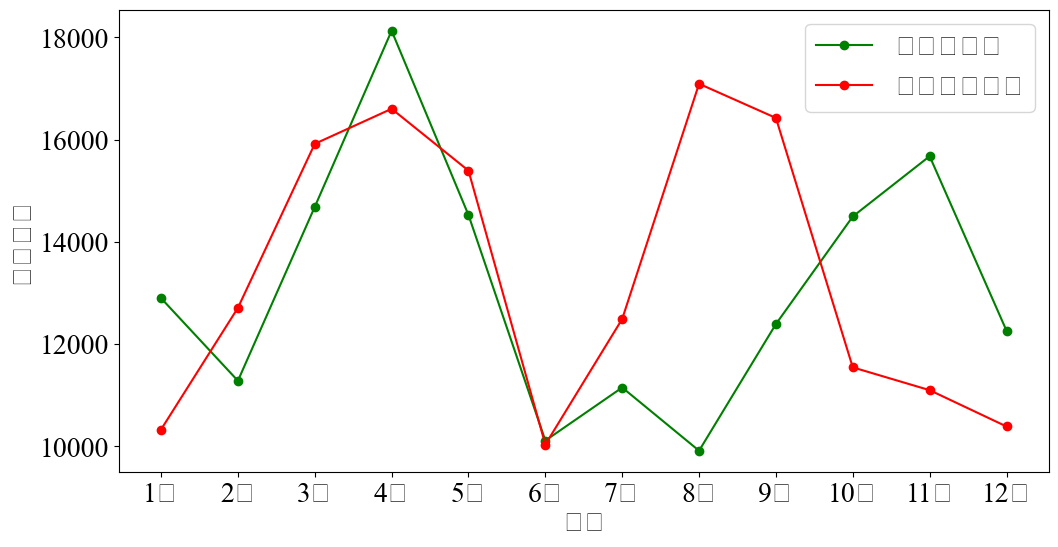

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# 确保 mask 的数据类型为 float32
mask = mask.astype(np.float32)

# 加载模型
eddynet = load_model(r'D:\EddyNet\EddyNet-master\EddyNet_new\weights\eddynet8.h5', 
                     custom_objects={'dice_coef_anti': dice_coef_anti, 
                                     'dice_coef_cyc': dice_coef_cyc, 
                                     'dice_coef_nn': dice_coef_nn,
                                     'mean_dice_coef': mean_dice_coef,
                                     'weighted_mean_dice_coef': weighted_mean_dice_coef,
                                     'dice_coef_loss': dice_coef_loss})

# 定义每个月的索引范围
months_ranges = [
    (0, 30),    # 1月
    (31, 58),   # 2月
    (59, 89),   # 3月
    (90, 119),  # 4月
    (120, 150), # 5月
    (151, 180), # 6月
    (181, 211), # 7月
    (212, 242), # 8月
    (243, 272), # 9月
    (273, 303), # 10月
    (304, 333), # 11月
    (334, 364)  # 12月
]

# 用于统计涡旋面积的列表
cyclonic_area_per_month = []
anticyclonic_area_per_month = []

# 遍历每个月
for start_day, end_day in months_ranges:
    cyclonic_area = 0
    anticyclonic_area = 0
    
    for day in range(start_day, end_day + 1):
        predictedSEGM = eddynet.predict(np.reshape(SSH_test[day, :, :], (1, SSH_test.shape[1], SSH_test.shape[2], 1)))
        predictedSEGMimage = np.reshape(predictedSEGM.argmax(2), (SSH_test.shape[1], SSH_test.shape[2]))
        
        # 统计像元数量作为涡旋面积
        cyclonic_area += np.sum(predictedSEGMimage == 1)
        anticyclonic_area += np.sum(predictedSEGMimage == 2)
    
    cyclonic_area_per_month.append(cyclonic_area)
    anticyclonic_area_per_month.append(anticyclonic_area)

# 打印每个月的气旋涡和反气旋涡的面积
for i, month in enumerate(['1月', '2月', '3月', '4月', '5月', '6月', '7月', '8月', '9月', '10月', '11月', '12月']):
    print(f"{month}: 气旋涡面积 = {cyclonic_area_per_month[i]}, 反气旋涡面积 = {anticyclonic_area_per_month[i]}")

# 绘制折线图
months = ['1月', '2月', '3月', '4月', '5月', '6月', '7月', '8月', '9月', '10月', '11月', '12月']

plt.figure(figsize=(12, 6))
plt.plot(months, cyclonic_area_per_month, marker='o', color='green', label='气旋涡面积')
plt.plot(months, anticyclonic_area_per_month, marker='o', color='red', label='反气旋涡面积')

plt.xlabel('月份', fontweight='bold')
plt.ylabel('涡旋面积', fontweight='bold')
plt.legend()

plt.show()


In [46]:
!pip install cartopy

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.0 MB 5.6 MB/s eta 0:00:02
   ---- ----------------------------------- 1.3/11.0 MB 4.2 MB/s eta 0:00:03
   -------- ------------------------------- 2.4/11.0 MB 5.4 MB/s eta 0:00:02
   ---------------- ----------------------- 4.5/11.0 MB 6.4 MB/s eta 0:00:02
   ---------------------- ----------------- 6.3/11.0 MB 6.9 MB/s eta 0:00:01
   --------------------------- ------------ 7.6/11.0 MB 6.8 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 8.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
   ----- ---------------------------------- 0.8/6.2 MB 11.2 MB/s eta 0:00:01
   ----------- ---------------------------- 1.8/6.2 MB 5.3 MB/s eta 0:00:01
   ------------------------- -------------- 3.9/6.2 MB 7.6 MB/s eta 0:00:01
   -------------------------------------- - 6.0/6.2 MB 8.4 MB/s eta 0:00:01
   -------------


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


(100.0, 124.0)

(0.0, 24.0)

Text(0.5, 0, '经度')

Text(0, 0.5, '纬度')

Text(0.5, 1.0, '南海区域地形示意图')

D:\python_jupyter\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python_jupyter\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28023 (\N{CJK UNIFIED IDEOGRAPH-6D77}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python_jupyter\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python_jupyter\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22495 (\N{CJK UNIFIED IDEOGRAPH-57DF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python_jupyter\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22320 (\N{CJK UNIFIED IDEOGRAPH-5730}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\python_jupyter\Lib\sit

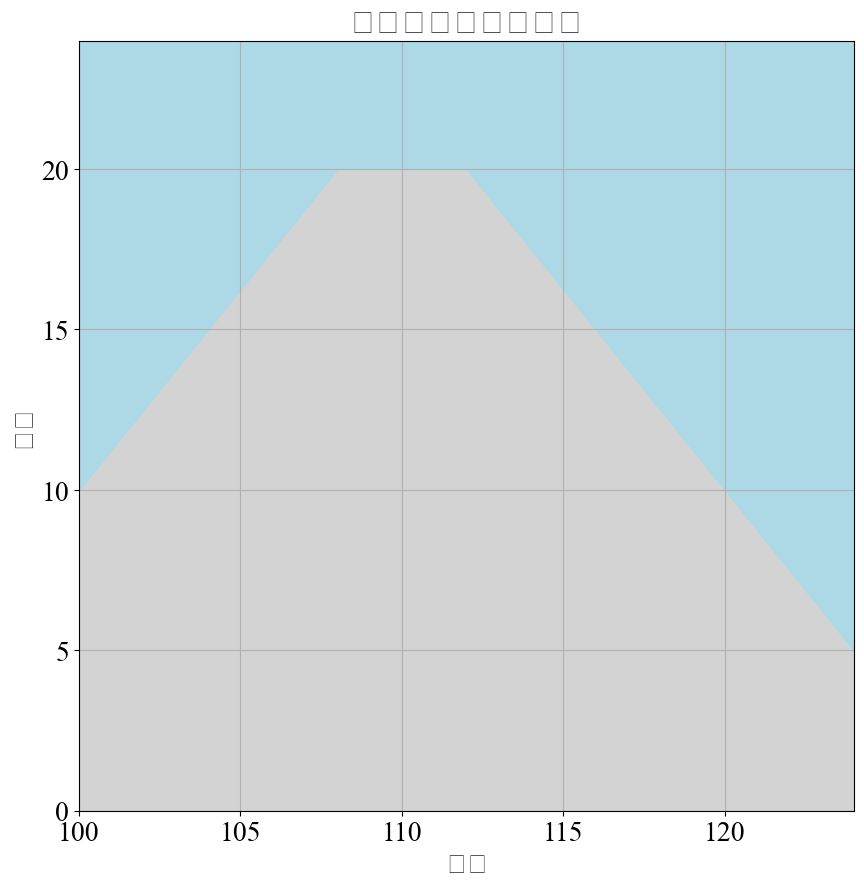

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# 创建绘图对象
fig, ax = plt.subplots(figsize=(10, 10))

# 设置经纬度范围
ax.set_xlim(100, 124)
ax.set_ylim(0, 24)

# 绘制海岸线的经纬度点
coastline_lon = [100, 104, 108, 112, 116, 120, 124]
coastline_lat = [10, 15, 20, 20, 15, 10, 5]

# 绘制陆地和海洋
ax.fill_between(coastline_lon, coastline_lat, 0, color='lightgray')
ax.fill_between(coastline_lon, coastline_lat, 24, color='lightblue')

# 添加经纬度网格
ax.set_xticks(np.arange(100, 125, 5))
ax.set_yticks(np.arange(0, 25, 5))
ax.grid(True)

# 添加经纬度标签
ax.set_xlabel('经度')
ax.set_ylabel('纬度')

# 添加图标题
plt.title('南海区域地形示意图')

# 显示图像
plt.show()
